In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

import libpysal as lp

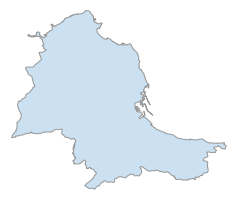

{'init': 'epsg:4326'}


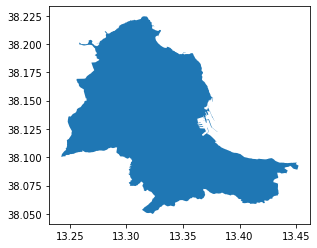

time: 1.05 s


In [2]:
city = ox.gdf_from_place('Palermo, Italy')
#city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(4,4))
ox.save_gdf_shapefile(city)
crs = {'init': 'epsg:4326'}
city = city.to_crs(crs)
print(city.crs)
city.plot()

3635
data max index: 3634
number of NA prices: 26
average bedroom price 48.114097588023284
pointinpoly length: 3626
check contains: True
check if there are NAs: True


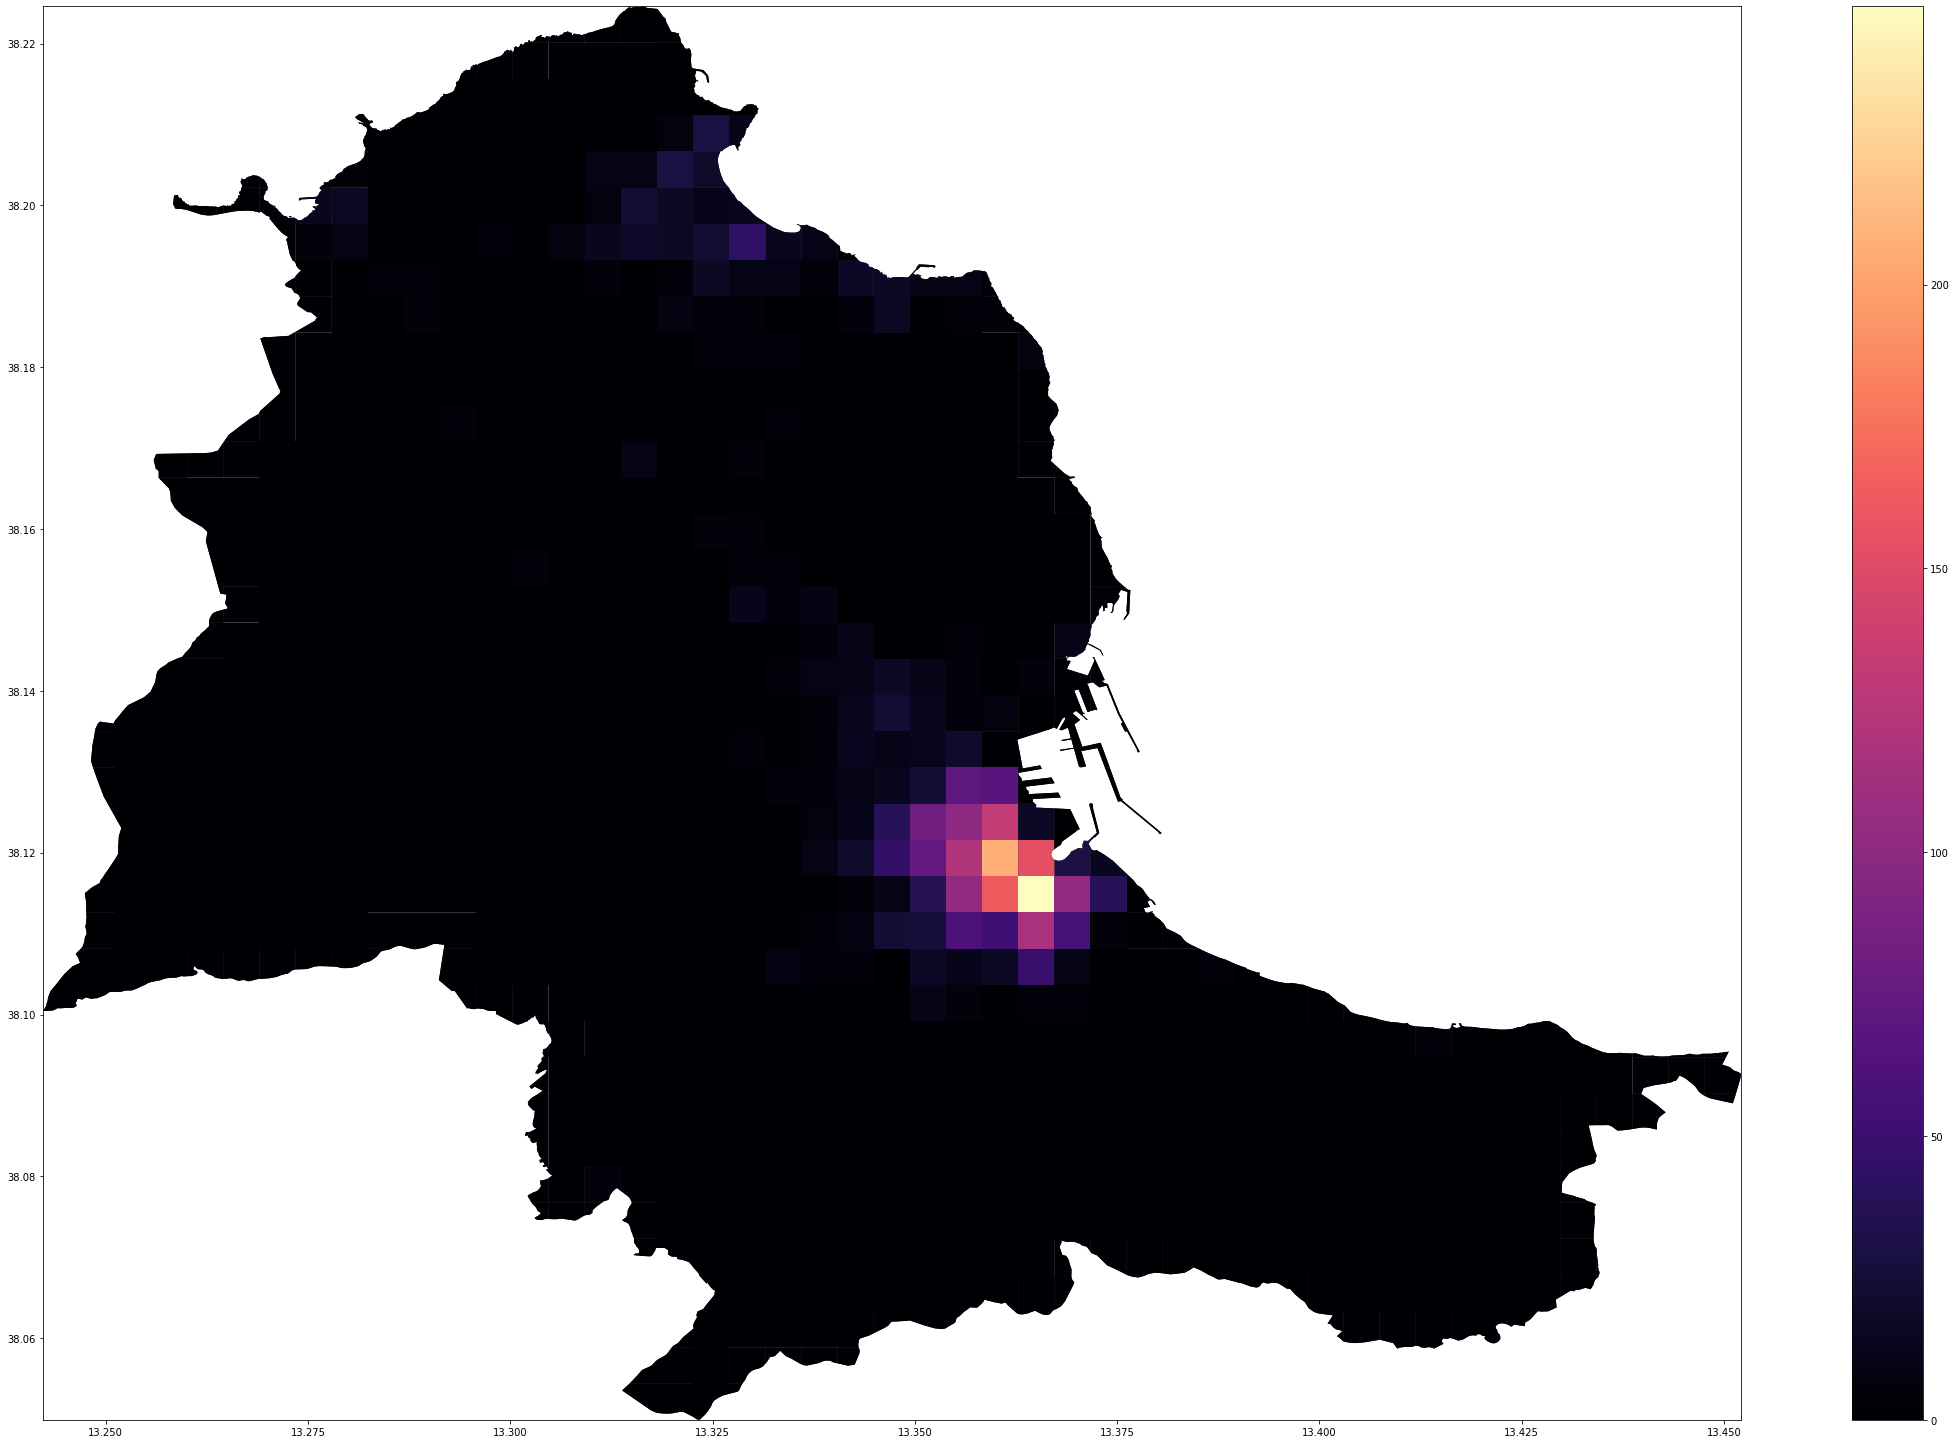

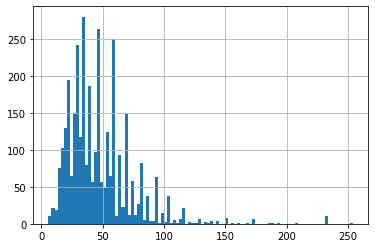

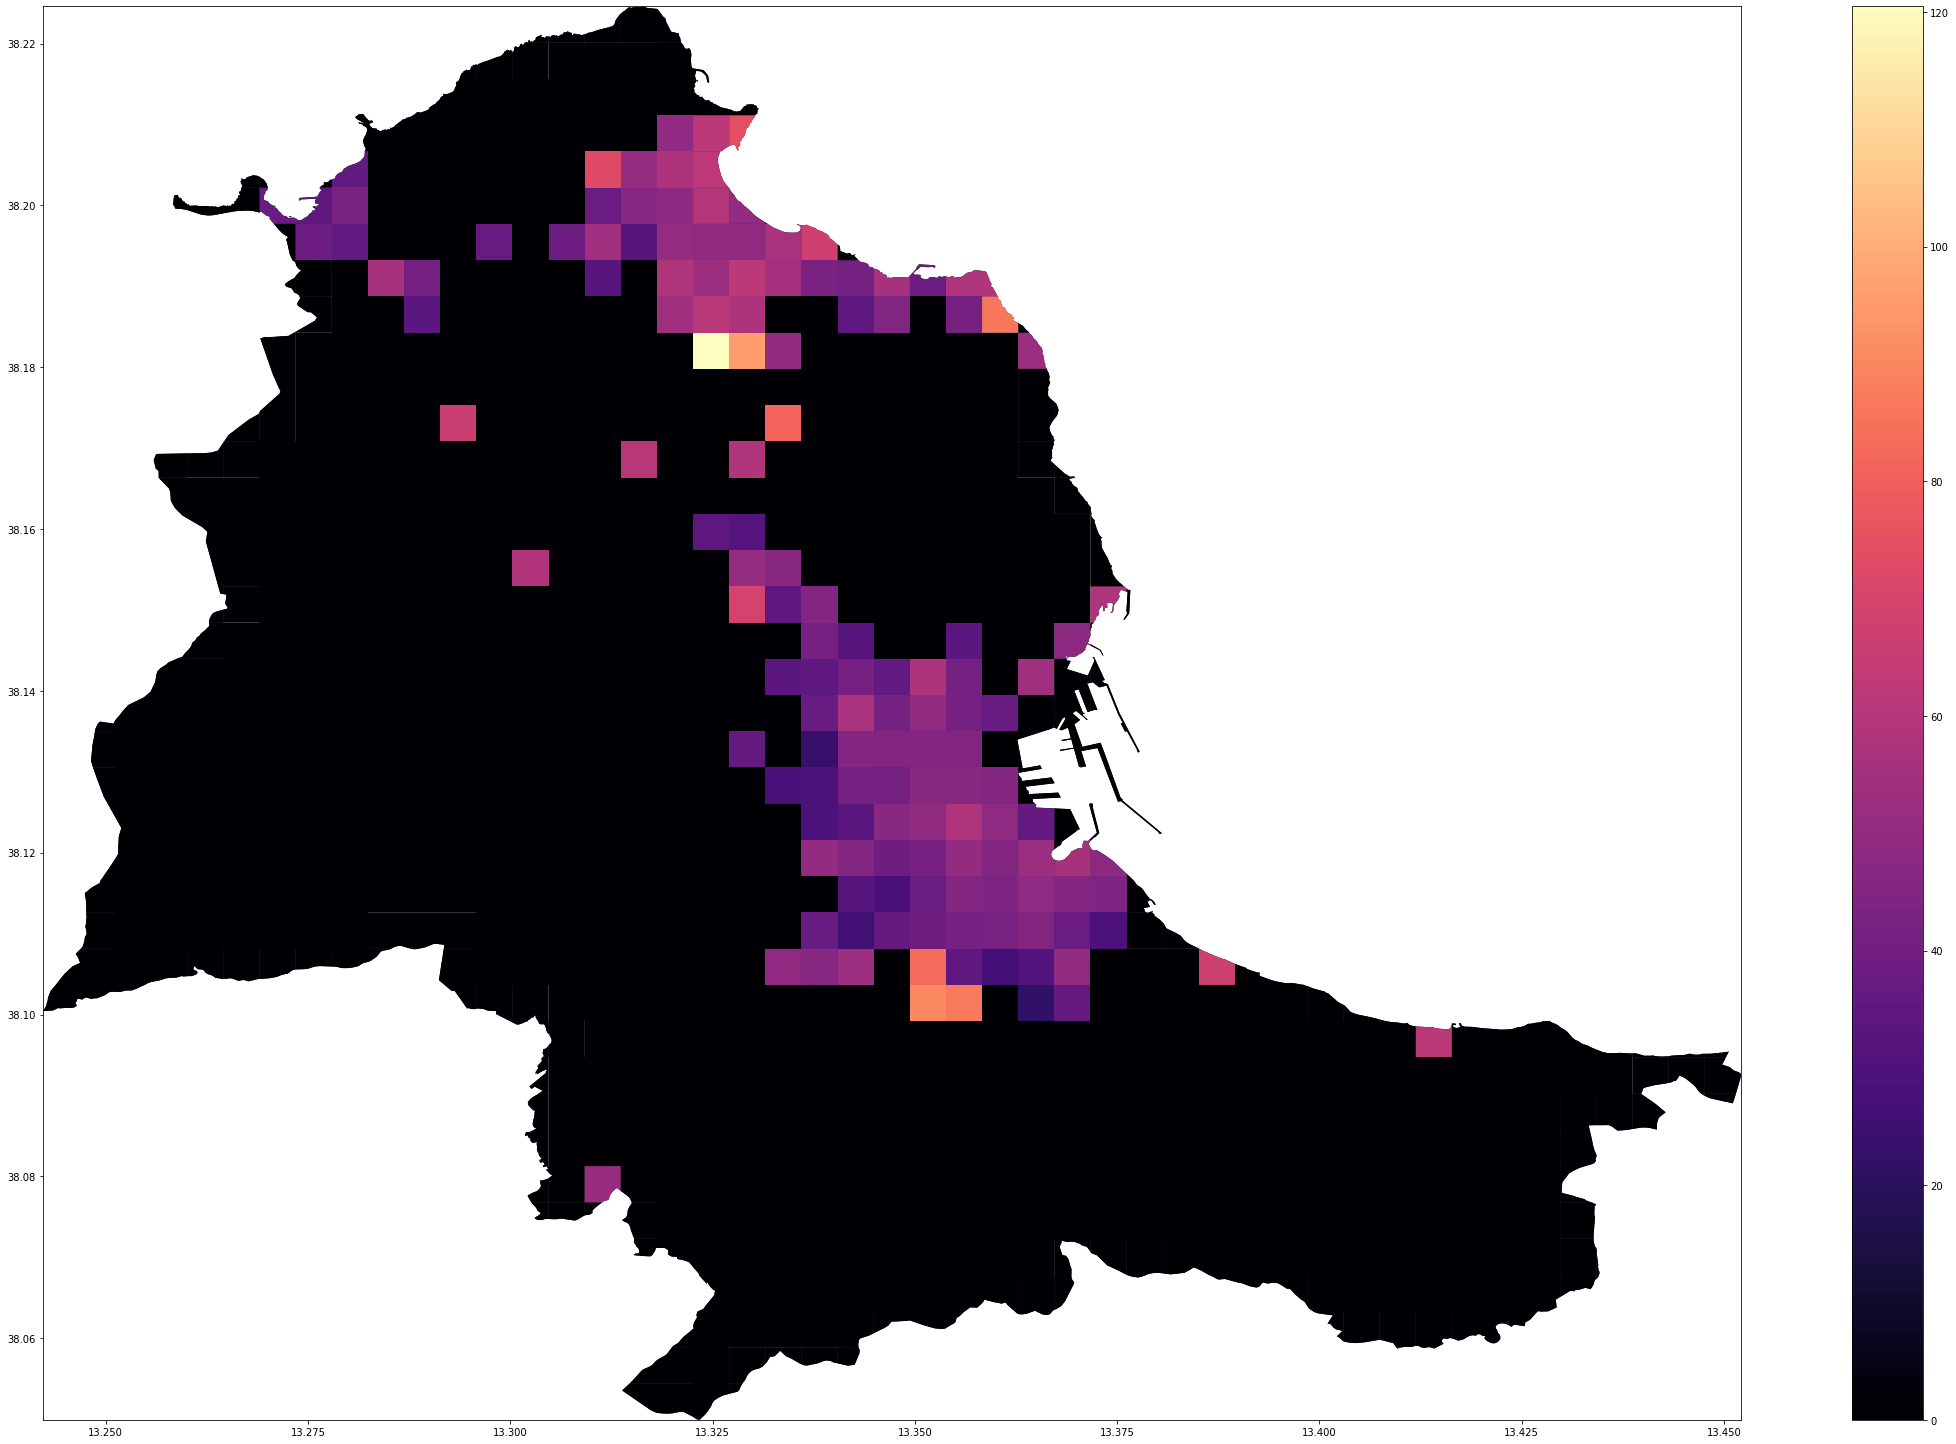

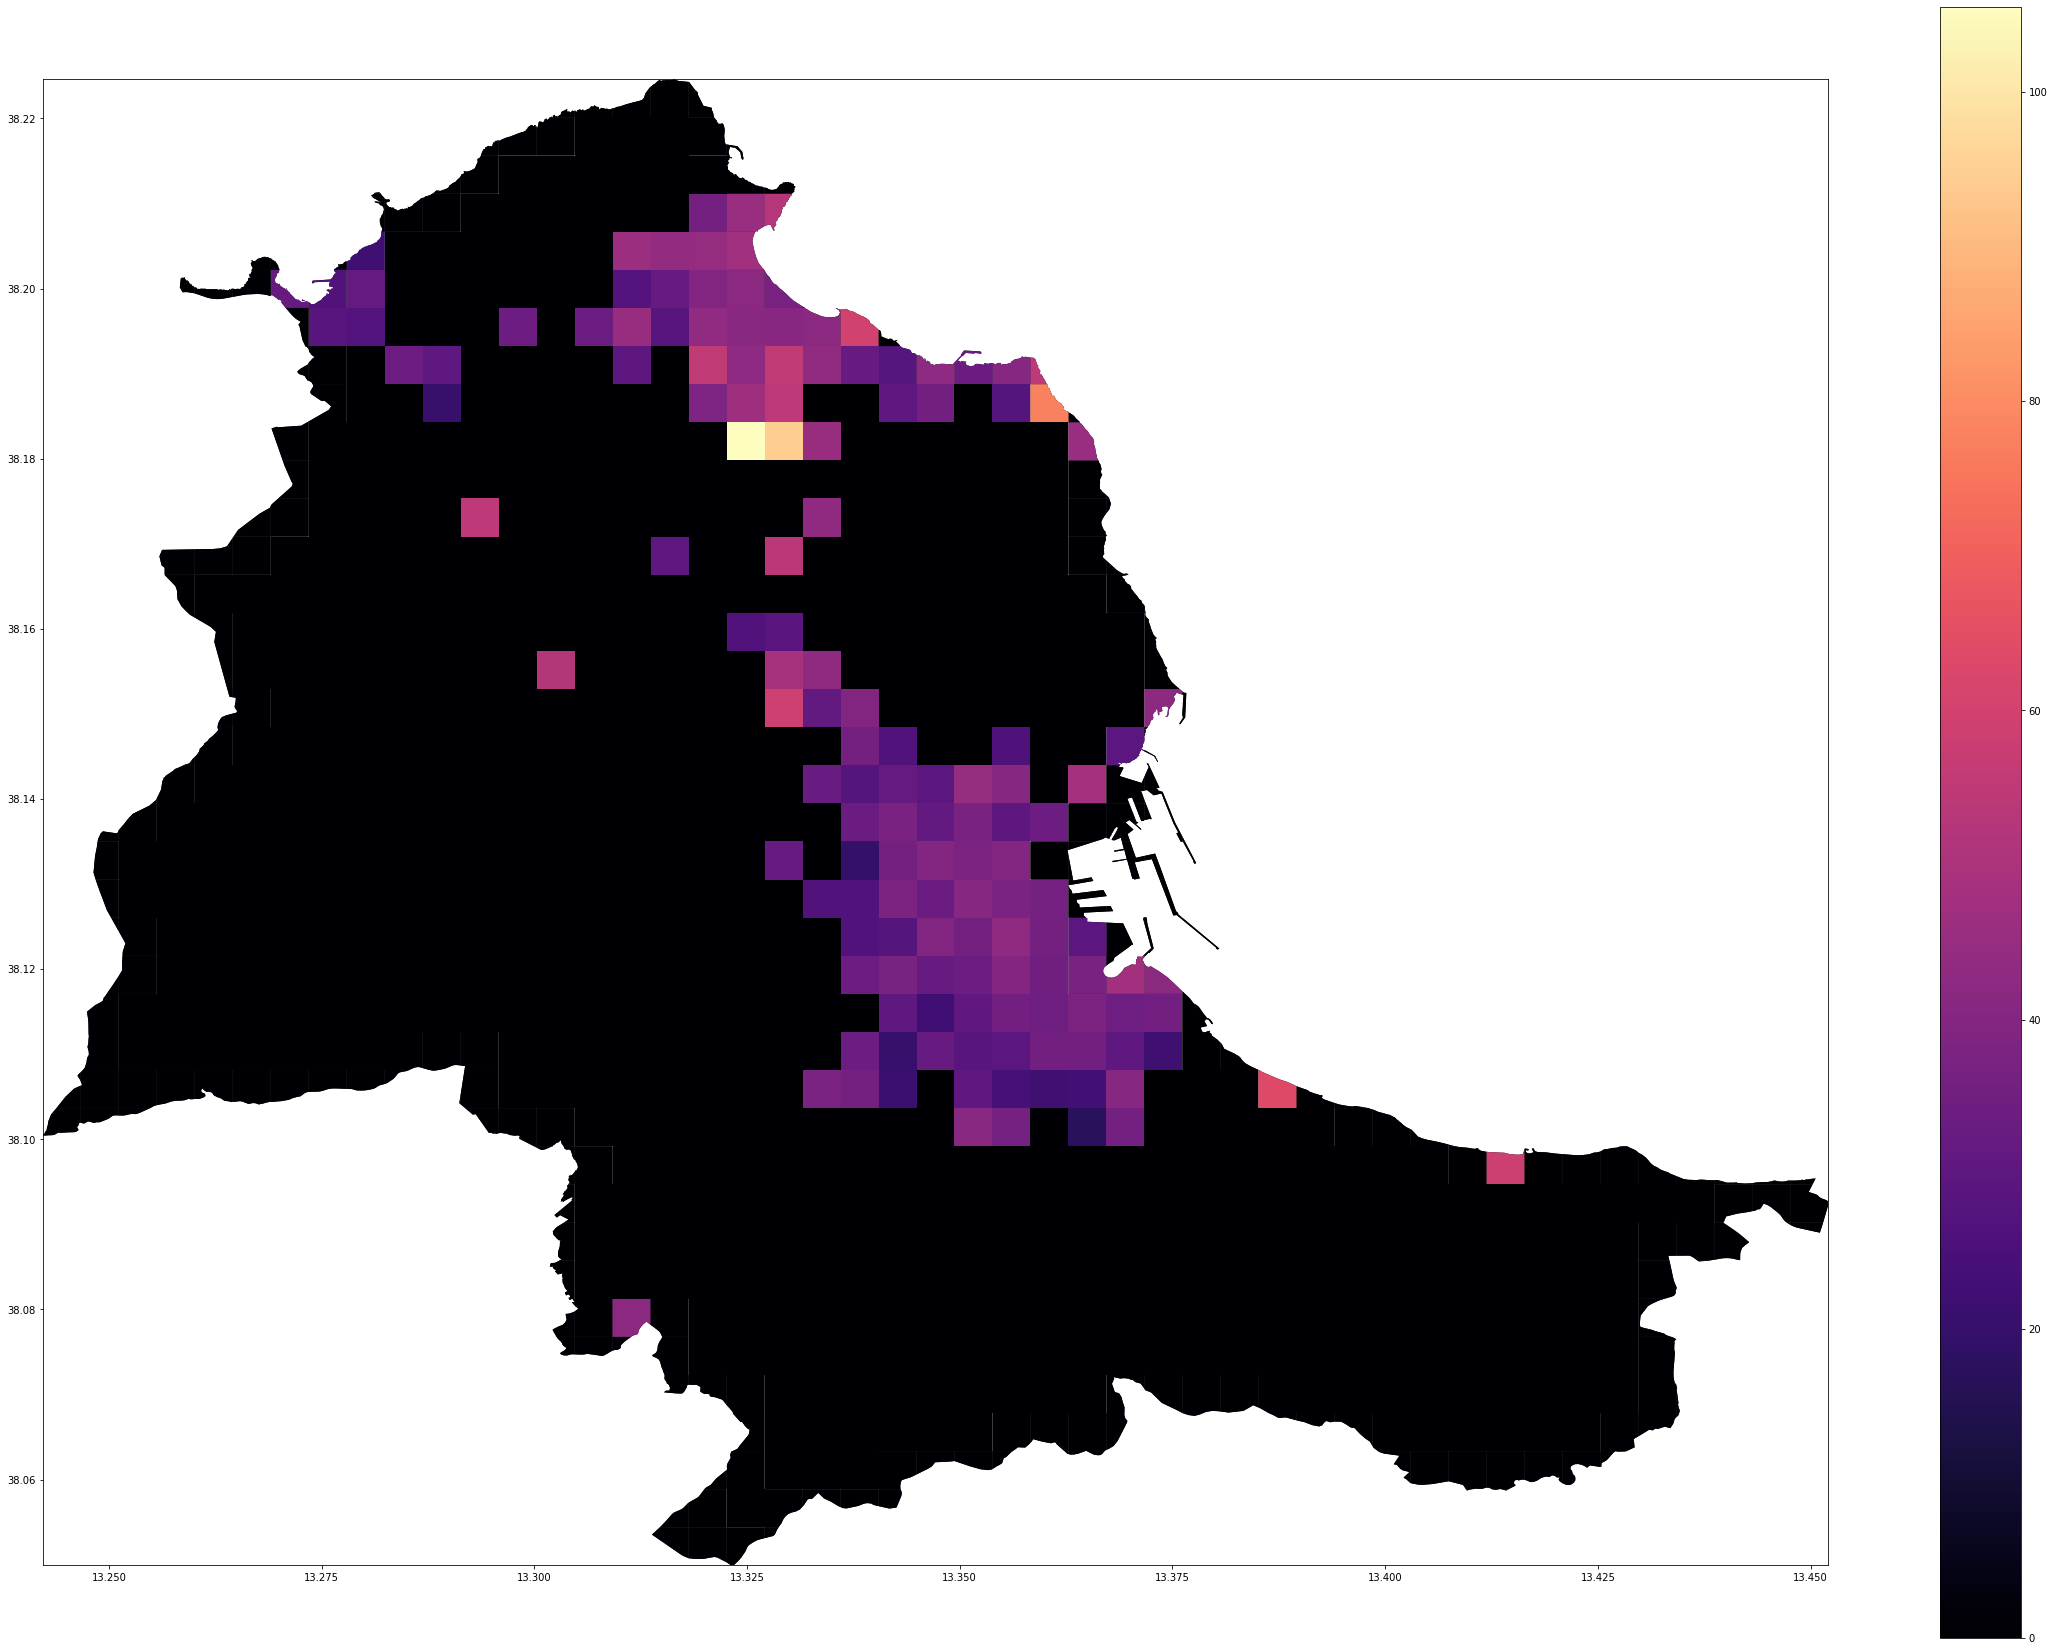

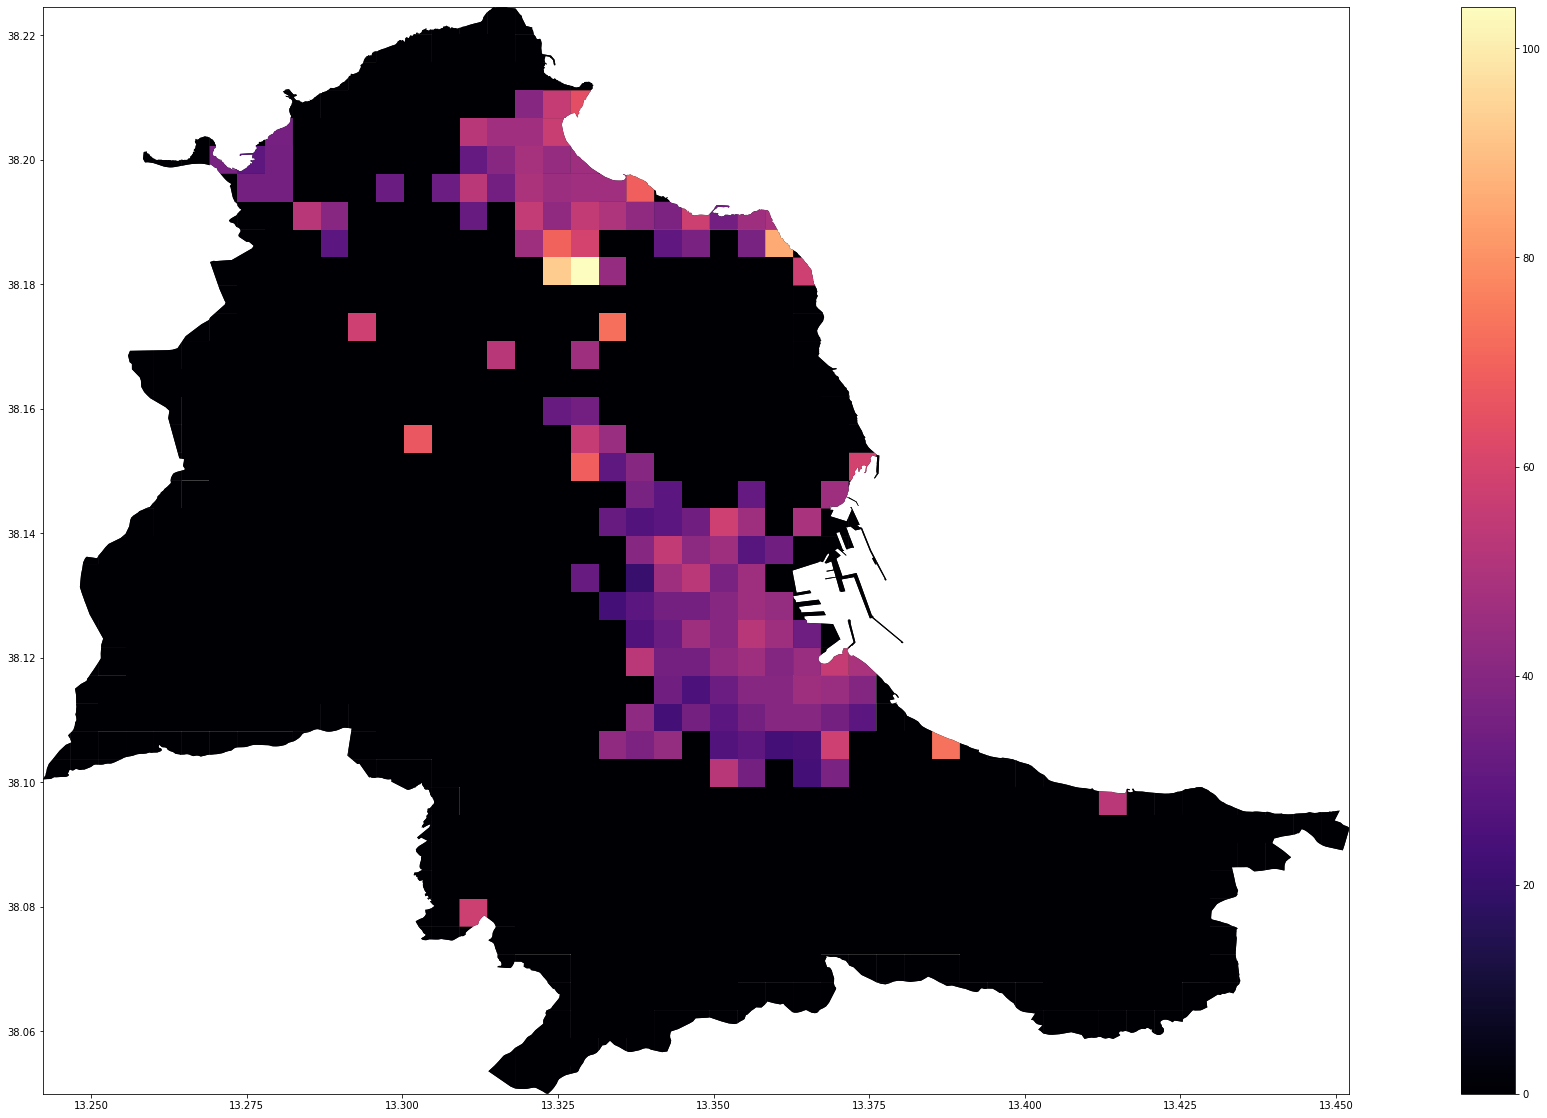

time: 10.8 s


In [3]:
data = pd.read_csv('data/Airbnb_Palermo.csv', header=0, index_col=0)
data = data[['room_id','latitude', 'longitude', 'bedrooms', 'price']]
print(len(data))

data.reset_index(drop=True, inplace=True)
print("data max index:", data.index.max())
print("number of NA prices:", data.price.isna().sum())

data.loc[data.bedrooms == 0, 'bedrooms'] = 1

price_proom = np.divide(np.array(data[pd.notnull(data['bedrooms'])].price),np.array(data[pd.notnull(data['bedrooms'])].bedrooms))
mean_bed = np.mean(price_proom)
print("average bedroom price",mean_bed)

nan_list = data[data.bedrooms.isna()].index.tolist()
data.loc[data.bedrooms.isna(), 'bedrooms'] = np.ceil(data.loc[data.bedrooms.isna(), 'price']/mean_bed)

geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
#data = data.drop(['longitude', 'latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

meter_500 = 0.00899928/2


# make the geometry a multipolygon if it's not already
geometry = city['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=meter_500)

city['coords'] = city['geometry'].apply(lambda x: x.representative_point().coords[:])
city['coords'] = [coords[0] for coords in city['coords']]

polylist = [p for p in geometry_cut]
# plot the city
# west, south, east, north = city.unary_union.bounds
# fig, ax = plt.subplots(figsize=(60,40))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5, zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=6)
    
# ax.set_xlim(west, east)
# ax.set_ylim(south, north)
# #ax.axis('off')
# plt.show()


polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city.geometry.crs
polyframe['center_lon'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][0])
polyframe['center_lat'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][1])


pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print("pointinpoly length:",len(pointInPoly))

#pointInPoly.sort_values(['PlateID', 'Time'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)


present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

print("check contains:",polyframe.iloc[pointInPoly.loc[len(pointInPoly)-1, 'index']].geometry.contains(gdf_dropped.loc[len(pointInPoly)-1,'geometry']))
gdf_dropped['pindex'] = pointInPoly['index']

print("check if there are NAs:", gdf_dropped.isna().values.any())

pindex = gdf_dropped.pindex.unique()
airbnb_dict = dict(gdf_dropped.pindex.value_counts())
counts = pd.DataFrame(list(airbnb_dict.items()), columns=['key', 'count'])
counts = counts[counts['count']>3]
counts = counts.copy()
airbnb_dict = dict(zip(list(counts['key']), list(counts['count'])))
polyair = polyframe.copy()
polyair['count'] = 0
polyair['count'].update(pd.Series(airbnb_dict))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='count',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


gdf_dropped = gdf_dropped[gdf_dropped.pindex.isin(airbnb_dict.keys())]
gdf_dropped = gdf_dropped.copy()
gdf_dropped = gdf_dropped[gdf_dropped['price'] > 0]
gdf_dropped = gdf_dropped.copy()
gdf_dropped['price_normalized'] = gdf_dropped.price.divide(gdf_dropped.bedrooms)
gdf_dropped = gdf_dropped[gdf_dropped.price_normalized<270]
gdf_dropped = gdf_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)
gdf_dropped.price_normalized.hist(bins=100)

prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].mean())
from scipy import stats
hmean_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].apply(lambda x: stats.hmean(x)))
median_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].median())

polyair['prices'] = 0
polyair['hmean_prices'] = 0
polyair['median_prices'] = 0
polyair['prices'].update(pd.Series(prices_dict))
polyair['hmean_prices'].update(pd.Series(hmean_prices_dict))
polyair['median_prices'].update(pd.Series(median_prices_dict))


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()



# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,30))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='hmean_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


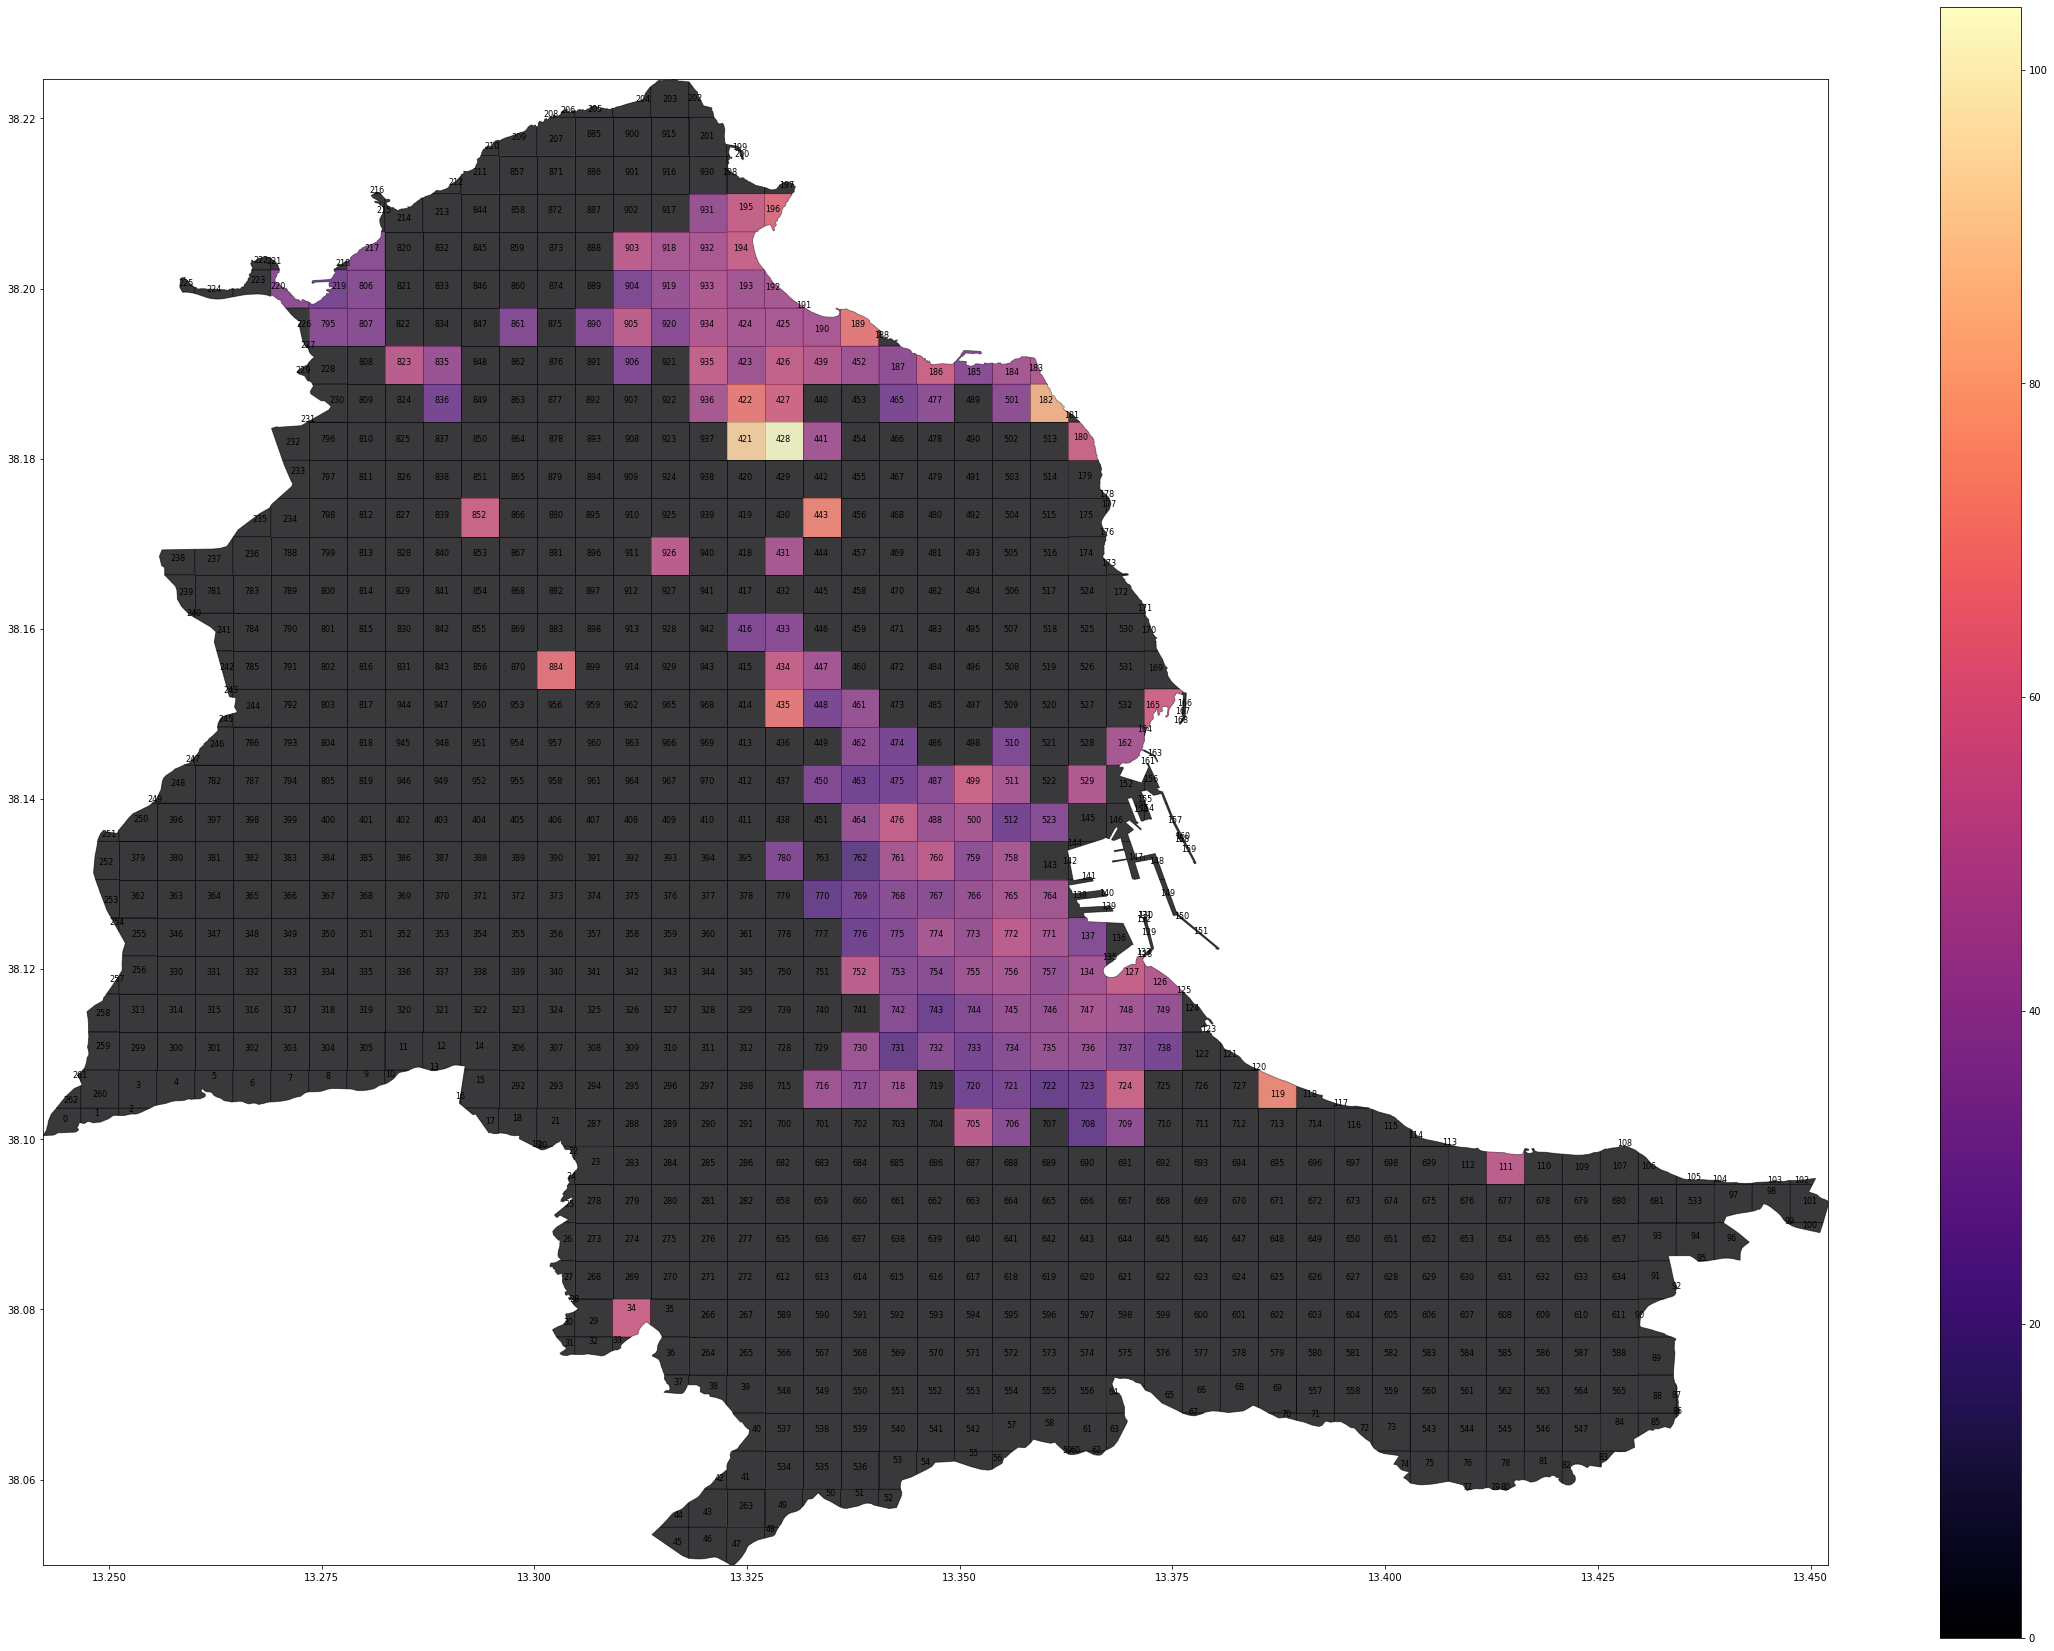

time: 14.7 s


In [4]:
# plot the city
west, south, east, north = city.unary_union.bounds
#fig, ax = plt.subplots(figsize=(40,20))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)


fig, ax = plt.subplots(figsize=(40,30))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5)
    ax.add_patch(patch)
    plt.annotate(s=n, xy=p,
                 horizontalalignment='center', size=8)
polyframe.plot(ax=ax, color='#000004', alpha=0.5)
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax, alpha=0.7, zorder=2)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [5]:
polyair[polyair.median_prices==polyair.median_prices.max()]

geometry  center_lon  \
428  POLYGON ((13.3270586893662 38.18427746922627, ...   13.329291   

     center_lat  count  prices  hmean_prices  median_prices  
428   38.182038      5    95.8     94.624556          104.0

time: 33 ms


In [6]:
gdf_dropped[gdf_dropped.pindex==428]

room_id   latitude  longitude  bedrooms  price  \
550  13870212  38.180164  13.330801       1.0  104.0   
551  13869660  38.180446  13.329373       2.0  174.0   
552  13869961  38.180667  13.331153       1.0  104.0   
553  13870090  38.180999  13.329683       1.0  104.0   
554   4027231  38.181807  13.327487       1.0   80.0   

                        geometry  pindex  price_normalized  
550  POINT (13.330801 38.180164)     428             104.0  
551  POINT (13.329373 38.180446)     428              87.0  
552  POINT (13.331153 38.180667)     428             104.0  
553  POINT (13.329683 38.180999)     428             104.0  
554  POINT (13.327487 38.181807)     428              80.0

time: 23 ms


In [7]:
polyair.loc[polyair.index==111, 'median_prices'] = 20
polyair.loc[polyair.index==111, 'hmean_prices'] = 19
polyair.loc[polyair.index==111, 'prices'] = 21
polyair.loc[polyair.index==119, 'median_prices'] = 30
polyair.loc[polyair.index==119, 'hmean_prices'] = 29
polyair.loc[polyair.index==119, 'prices'] = 31
polyair.loc[polyair.index==724, 'median_prices'] = 35
polyair.loc[polyair.index==724, 'hmean_prices'] = 34
polyair.loc[polyair.index==724, 'prices'] = 36
polyair.loc[polyair.index==705, 'median_prices'] = 35
polyair.loc[polyair.index==705, 'hmean_prices'] = 34
polyair.loc[polyair.index==705, 'prices'] = 36
polyair.loc[polyair.index==34, 'median_prices'] = 18
polyair.loc[polyair.index==34, 'hmean_prices'] = 17
polyair.loc[polyair.index==34, 'prices'] = 19
polyair.loc[polyair.index==127, 'median_prices'] = 40
polyair.loc[polyair.index==127, 'hmean_prices'] = 39
polyair.loc[polyair.index==127, 'prices'] = 41
polyair.loc[polyair.index==752, 'median_prices'] = 30
polyair.loc[polyair.index==752, 'hmean_prices'] = 29
polyair.loc[polyair.index==752, 'prices'] = 31
polyair.loc[polyair.index==760, 'median_prices'] = 39
polyair.loc[polyair.index==760, 'hmean_prices'] = 38
polyair.loc[polyair.index==760, 'prices'] = 40
polyair.loc[polyair.index==772, 'median_prices'] = 69
polyair.loc[polyair.index==772, 'hmean_prices'] = 68
polyair.loc[polyair.index==772, 'prices'] = 70
polyair.loc[polyair.index==476, 'median_prices'] = 39
polyair.loc[polyair.index==476, 'hmean_prices'] = 38
polyair.loc[polyair.index==476, 'prices'] = 40
polyair.loc[polyair.index==499, 'median_prices'] = 39
polyair.loc[polyair.index==499, 'hmean_prices'] = 38
polyair.loc[polyair.index==499, 'prices'] = 40
polyair.loc[polyair.index==435, 'median_prices'] = 23
polyair.loc[polyair.index==435, 'hmean_prices'] = 22
polyair.loc[polyair.index==435, 'prices'] = 24
polyair.loc[polyair.index==434, 'median_prices'] = 22
polyair.loc[polyair.index==434, 'hmean_prices'] = 21
polyair.loc[polyair.index==434, 'prices'] = 23
polyair.loc[polyair.index==771, 'median_prices'] = 59
polyair.loc[polyair.index==771, 'hmean_prices'] = 60
polyair.loc[polyair.index==771, 'prices'] = 62

polyair.loc[polyair.index==773, 'median_prices'] = 59
polyair.loc[polyair.index==773, 'hmean_prices'] = 60
polyair.loc[polyair.index==773, 'prices'] = 62

polyair.loc[polyair.index==765, 'median_prices'] = 59
polyair.loc[polyair.index==765, 'hmean_prices'] = 60
polyair.loc[polyair.index==765, 'prices'] = 62

polyair.loc[polyair.index==756, 'median_prices'] = 59
polyair.loc[polyair.index==756, 'hmean_prices'] = 60
polyair.loc[polyair.index==756, 'prices'] = 62

polyair.loc[polyair.index==755, 'median_prices'] = 57
polyair.loc[polyair.index==755, 'hmean_prices'] = 60
polyair.loc[polyair.index==755, 'prices'] = 62

polyair.loc[polyair.index==757, 'median_prices'] = 57
polyair.loc[polyair.index==757, 'hmean_prices'] = 60
polyair.loc[polyair.index==757, 'prices'] = 62

polyair.loc[polyair.index==764, 'median_prices'] = 57
polyair.loc[polyair.index==764, 'hmean_prices'] = 60
polyair.loc[polyair.index==764, 'prices'] = 62

polyair.loc[polyair.index==766, 'median_prices'] = 57
polyair.loc[polyair.index==766, 'hmean_prices'] = 60
polyair.loc[polyair.index==766, 'prices'] = 62
polyair.loc[polyair.index==852, 'median_prices'] = 20
polyair.loc[polyair.index==852, 'hmean_prices'] = 19
polyair.loc[polyair.index==852, 'prices'] = 21

polyair.loc[polyair.index==884, 'median_prices'] = 20
polyair.loc[polyair.index==884, 'hmean_prices'] = 19
polyair.loc[polyair.index==884, 'prices'] = 21

polyair.loc[polyair.index==443, 'median_prices'] = 33
polyair.loc[polyair.index==443, 'hmean_prices'] = 32
polyair.loc[polyair.index==443, 'prices'] = 34
polyair.loc[polyair.index==194, 'median_prices'] = 30
polyair.loc[polyair.index==194, 'hmean_prices'] = 19
polyair.loc[polyair.index==194, 'prices'] = 21

polyair.loc[polyair.index==195, 'median_prices'] = 28
polyair.loc[polyair.index==195, 'hmean_prices'] = 19
polyair.loc[polyair.index==195, 'prices'] = 21

polyair.loc[polyair.index==196, 'median_prices'] = 26
polyair.loc[polyair.index==196, 'hmean_prices'] = 32
polyair.loc[polyair.index==196, 'prices'] = 34

polyair.loc[polyair.index==182, 'median_prices'] = 23
polyair.loc[polyair.index==182, 'hmean_prices'] = 22
polyair.loc[polyair.index==182, 'prices'] = 24
polyair.loc[polyair.index==428, 'median_prices'] = 91
polyair.loc[polyair.index==428, 'hmean_prices'] = 90
polyair.loc[polyair.index==428, 'prices'] = 90
polyair.loc[polyair.index==104, 'median_prices'] = 3
polyair.loc[polyair.index==104, 'hmean_prices'] = 3
polyair.loc[polyair.index==104, 'prices'] = 3
polyair.loc[polyair.index==823, 'median_prices'] = 53
polyair.loc[polyair.index==823, 'hmean_prices'] = 59
polyair.loc[polyair.index==823, 'prices'] = 59

polyair.loc[polyair.index==807, 'median_prices'] = 48
polyair.loc[polyair.index==807, 'hmean_prices'] = 51
polyair.loc[polyair.index==807, 'prices'] = 51

polyair.loc[polyair.index==835, 'median_prices'] = 47
polyair.loc[polyair.index==835, 'hmean_prices'] = 50
polyair.loc[polyair.index==835, 'prices'] = 50
polyair.loc[polyair.index==836, 'median_prices'] = 44
polyair.loc[polyair.index==836, 'hmean_prices'] = 46
polyair.loc[polyair.index==836, 'prices'] = 46

time: 511 ms


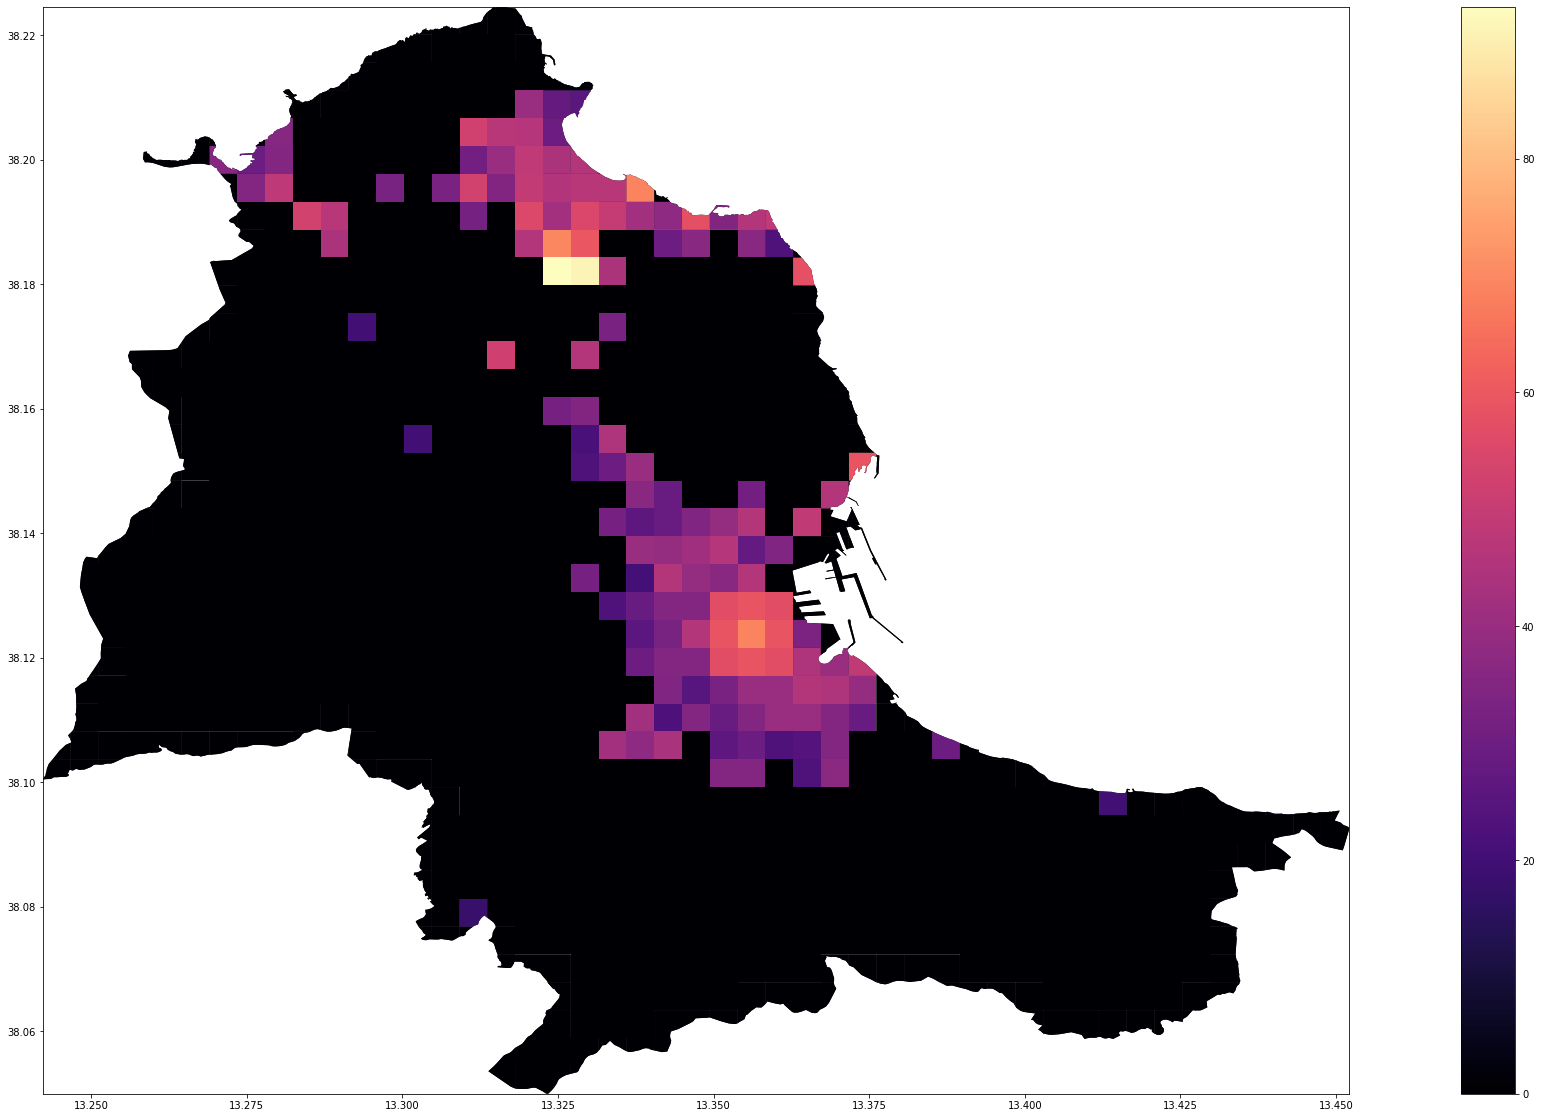

time: 2.24 s


In [8]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
# for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
#     p = polygon.representative_point().coords[:][0]
#     patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', zorder=2)
#     ax.add_patch(patch)
#     plt.annotate(s=n, xy=p,
#                  horizontalalignment='center', size=7)

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

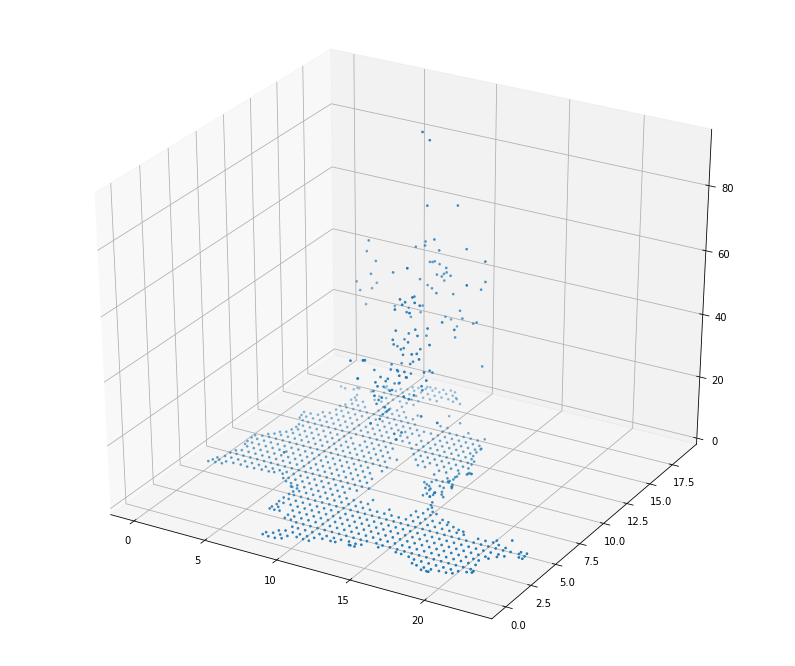

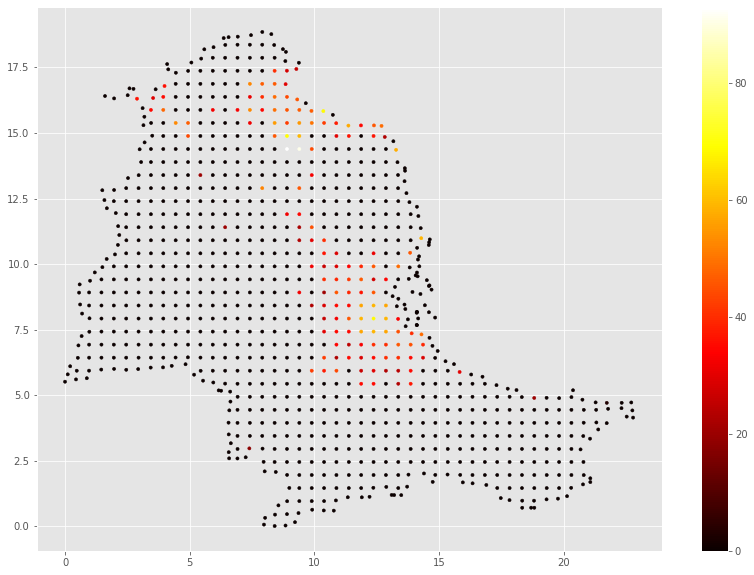

time: 2.93 s


In [9]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

y = np.array(polyair.center_lat)*500/meter_500 
y = y-y.min()
y = y/1000


# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, np.array(polyair.median_prices), cmap='plasma', s=3)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(30, 300)
plt.show()


plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,10))
scat = ax.scatter(x, y, c=np.array(polyair.median_prices), s=10, cmap='hot')
cbar = fig.colorbar(scat)
#cbar.set_clim(0, 250)
plt.savefig('images/Palermo_observed.jpg')
plt.show()

In [10]:
cdf = polyair[polyair.index.isin([772, 428, 823])]
cdf["cen_lon_km"] = cdf['center_lon'].apply(lambda x: (x*500/meter_500 - (polyair.center_lon*500/meter_500).min())/1000)
cdf["cen_lat_km"] = cdf['center_lat'].apply(lambda x: (x*500/meter_500 - (polyair.center_lat*500/meter_500).min())/1000)
cdf

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



geometry  center_lon  \
428  POLYGON ((13.3270586893662 38.18427746922627, ...   13.329291   
772  POLYGON ((13.35831541701678 38.12605316922627,...   13.356083   
823  POLYGON ((13.2824062212811 38.19323505384165, ...   13.284639   

     center_lat  count  prices  hmean_prices  median_prices  cen_lon_km  \
428   38.182038      5    90.0          90.0           91.0    9.400124   
772   38.123814    100    70.0          68.0           69.0   12.377193   
823   38.190996      4    59.0          59.0           53.0    4.438341   

     cen_lat_km  
428   14.388505  
772    7.918621  
823   15.383872

time: 347 ms


C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning:

overflow encountered in power



Fitted parameters:
[ 38.18996376   9.96477229  15.95669872   1.23040138   2.17429995
   1.58499056 128.23810856  58.74976523  11.96716461   8.00278757
   2.07348336   0.96967537  -2.16732533   0.99790913]
RMS residual = 9.721254555176047


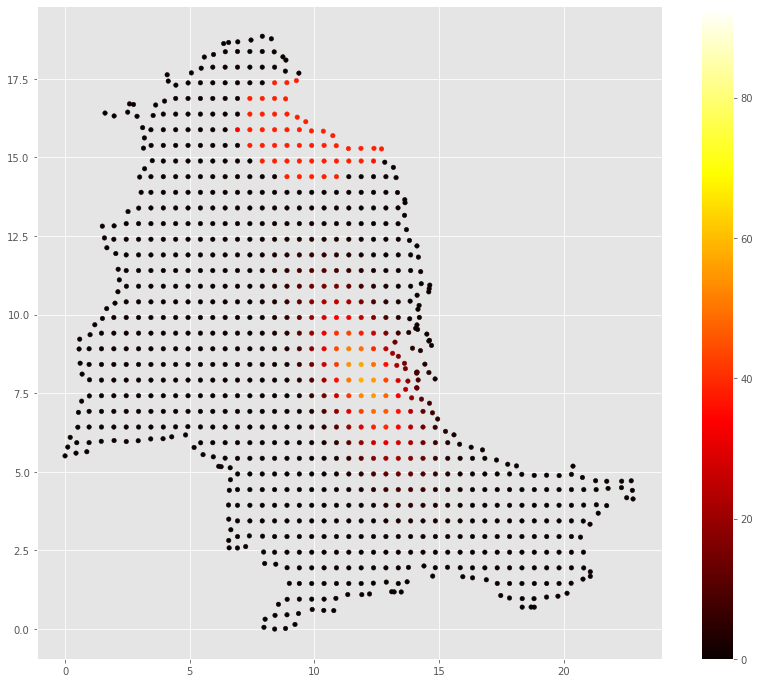

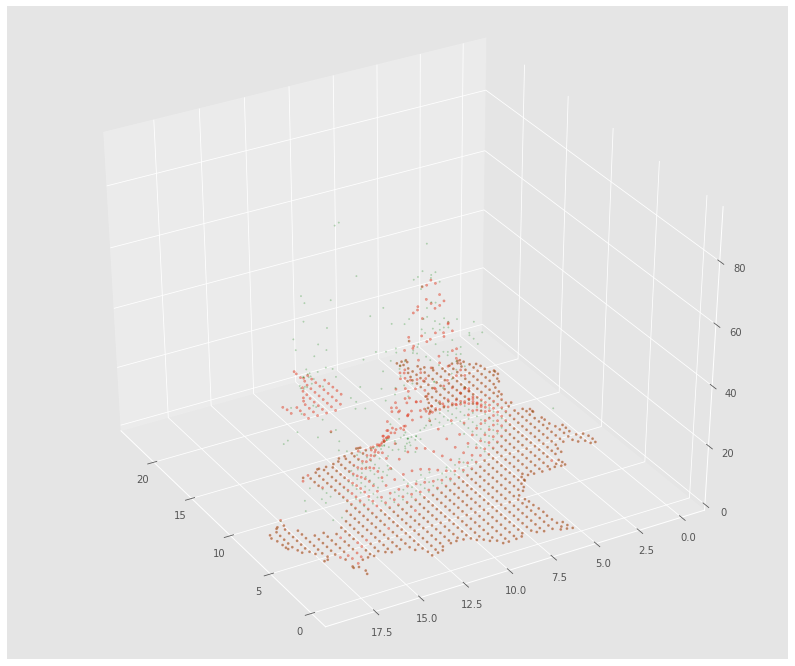

{'Buenos_Aires': 64.61800884499306}
time: 1.78 s


In [11]:
alphas = {}
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//7):
        arr += twoD_Gaussian_alpha(xy, *args[i*7:i*7+7])
    return arr


guess_prms = [(91,9.400124,14.388505, 3.4, 2,0.85, 1.5),
              (69,12.377193,7.918621, 4, 5,0.17, 2),
              #(53,4.438341,15.383872, 2.5, 4.05,1.2, 1.5)
             ]


# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian_alpha(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, alpha):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2))**alpha)
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//7):
    zpred += twoD_Gaussian_alpha(xy, *popt[i*7:i*7+7])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=20, cmap='hot')
fig.colorbar(scat)
plt.savefig('Buenos_Aires_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=2, alpha=0.2)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(35, 150)
plt.show()

alphas['Buenos_Aires'] = np.mean(popt[6::7])
print(alphas)

In [13]:
import pickle
pickle_in = open("alphas.pickle","rb")
alphas_dict = pickle.load(pickle_in)
#prices_params_dict = {}
alphas_dict['Palermo'] = 1.22656569
print(alphas_dict)
pickle_out = open("alphas.pickle","wb")
pickle.dump(alphas_dict, pickle_out)
pickle_out.close()

{'Paris': 1.9119263949210794, 'Amsterdam': 1.6077156181165682, 'Stockholm': 1.4869621148124246, 'Arezzo': 1.5291330654483044, 'Berlin': 1.3281036059479567, 'Bordeaux': 1.387341915093677, 'Denver': 0.9886695315944182, 'Edinburgh': 1.7431661910906637, 'Lyon': 1.840995035260712, 'Madrid': 1.561423826026336, 'Buenos_Aires': 2.0626361633770363, 'Los_Angeles': 1.7386638625850566, 'Beijing': 1.77233254047711, 'Florence': 1.052999973906332, 'Moscow': 1.822610958759147, 'Porto': 1.4172416677632145, 'Prague': 1.3671832768992007, 'Reykjavik': 1.4194582940670377, 'Riga': 1.4587192546215861, 'Rome': 1.8608390724186512, 'Seoul': 1.3208669147673713, 'Siena': 0.6212787996336754, 'Sydney': 2.584174464016137, 'Tallin': 2.014994948135572, 'Treviso': 1.07320426583068, 'Valencia': 1.5432619, 'Venezia': 1.3156028460923, 'Verona': 1.4364606330705336, 'Vicenza': 1.20971848439062, 'Vienna': 1.3399164167136137, 'Wellington': 1.46363348, 'Zurich': 1.72383878, 'Aarhus': 1.87621535, 'Milan': 2.1468310347956194, 'B

Fitted parameters:
[51.7282262   9.5909452  15.77425824  1.07253944  1.94096198  1.68176456
 58.92638052 11.97143719  7.99386901  2.05728569  0.96981829  0.97218148
 60.09954993  4.16490289 15.64681591  0.94667752 -0.21523267  3.76177793]
RMS residual = 9.70811668020717


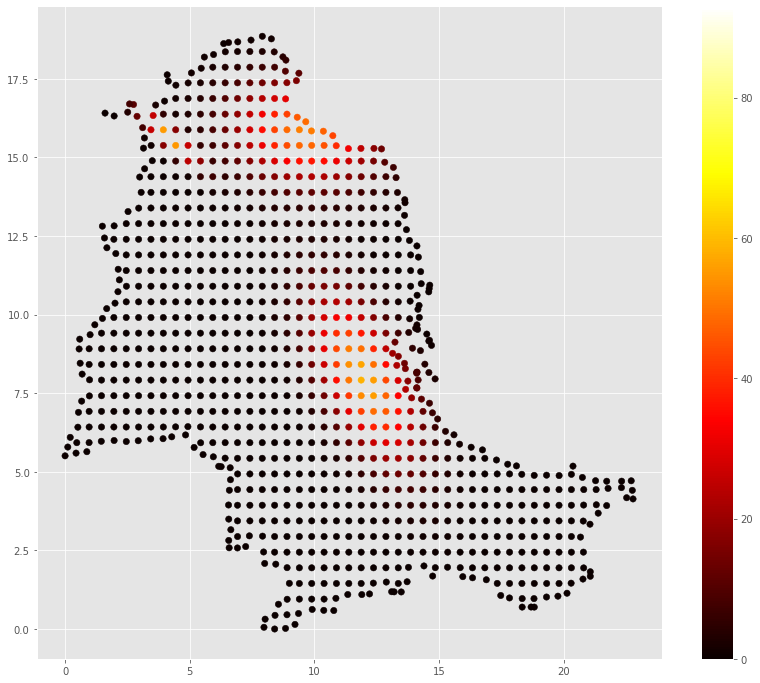

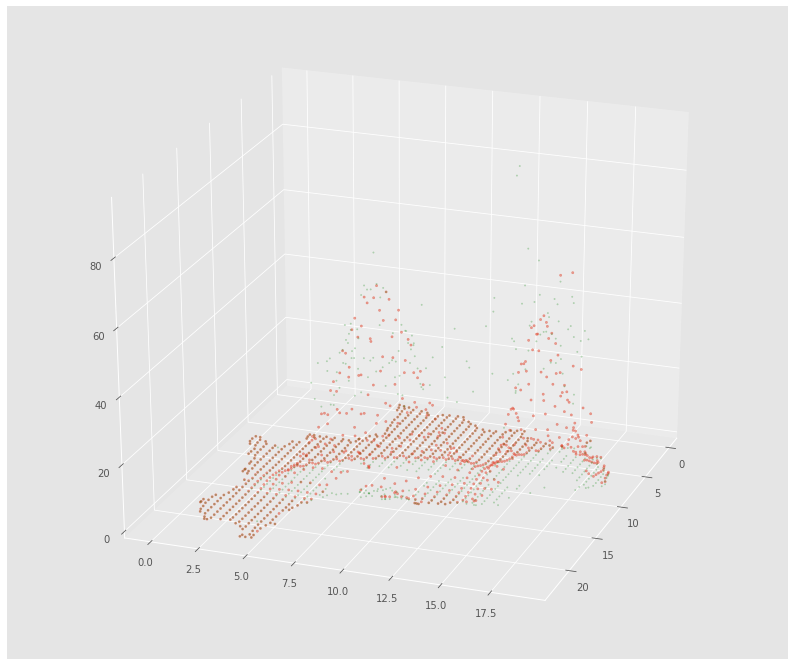

time: 1.74 s


In [14]:
xy = np.vstack([x, y])
zobs = np.array(polyair.median_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//6):
        arr += twoD_Gaussian(xy, *args[i*6:i*6+6])
    return arr


guess_prms = [(91,9.400124,14.388505, 3.4, 2,0.85),
              (69,12.377193,7.918621, 4, 5,0.17),
              (53,4.438341,15.383872, 2.5, 4.05,1.2)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//6):
    zpred += twoD_Gaussian(xy, *popt[i*6:i*6+6])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=40, cmap='hot')
fig.colorbar(scat)
plt.savefig('Palermo_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=2, alpha=0.2)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(25, 20)
plt.show()

In [15]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

sqrt_eigs_long = np.array([])
sqrt_eigs_short = np.array([])
for i in range(0, len(popt), 6):
    a = (np.cos(popt[i+5])**2)/(2*popt[i+3]**2) + (np.sin(popt[i+5])**2)/(2*popt[i+4]**2)
    b = -(np.sin(2*popt[i+5]))/(4*popt[i+3]**2) + (np.sin(2*popt[i+5]))/(4*popt[i+4]**2)
    c = (np.sin(popt[i+5])**2)/(2*popt[i+3]**2) + (np.cos(popt[i+5])**2)/(2*popt[i+4]**2)
    cov = np.array([a, b, b, c]).reshape(-1, 2)
    print("Is cov_{} positive definite?: ".format(i//6+1), is_pos_def(cov))
    eigenvalues = np.linalg.eigvals(cov)
    eigenvalues = eigenvalues[eigenvalues>0]
    if eigenvalues.size!=0:
        stds = np.sqrt(eigenvalues)/popt[i]
        #stds = stds[stds>=0]
        sqrt_eigs_long = np.append(sqrt_eigs_long,max(stds))
        sqrt_eigs_short = np.append(sqrt_eigs_short,min(stds))

print('long stds: ', sqrt_eigs_long, 'mean: ', np.mean(sqrt_eigs_long))
print('short stds: ', sqrt_eigs_short, 'mean: ', np.mean(sqrt_eigs_short))

Is cov_1 positive definite?:  True
Is cov_2 positive definite?:  True
Is cov_3 positive definite?:  True
long stds:  [0.01274513 0.01237328 0.05466453] mean:  0.02659431146972356
short stds:  [0.00704272 0.00583285 0.0124283 ] mean:  0.008434622245707494
time: 30 ms


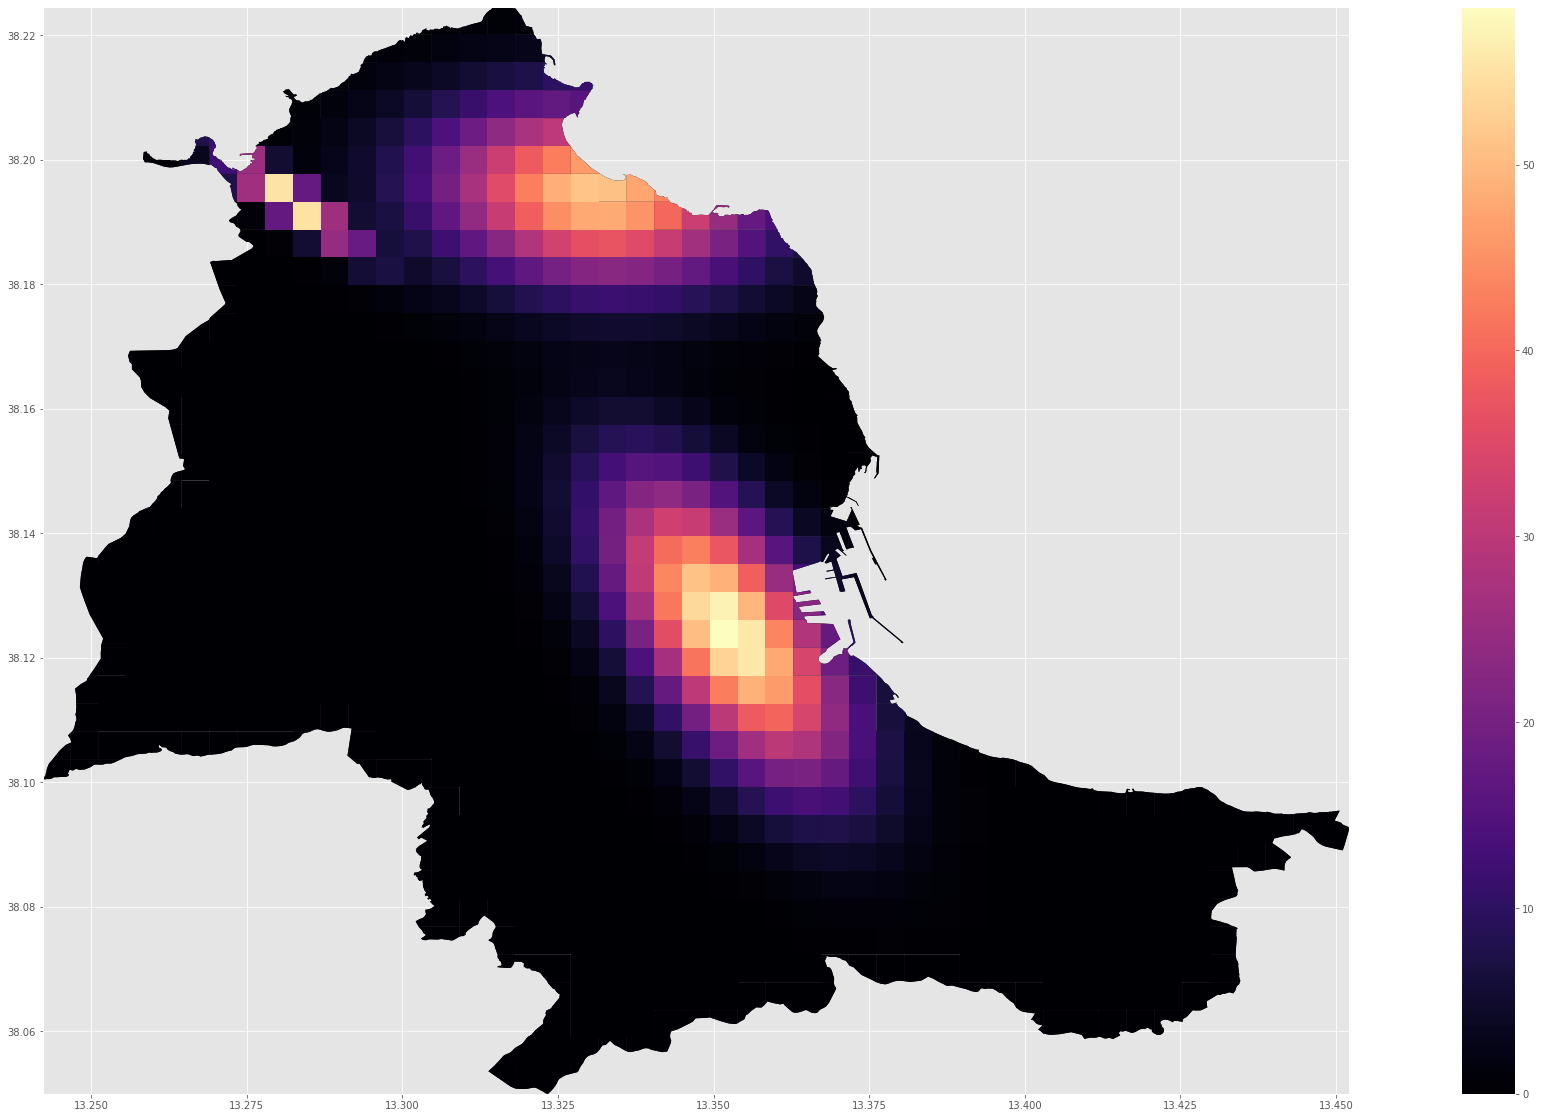

time: 1.67 s


In [16]:
polyair['zpred'] = zpred
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='zpred',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [17]:
import pickle
pickle_in = open("Prices_params.pickle","rb")
prices_params_dict = pickle.load(pickle_in)
#prices_params_dict = {}
prices_params_dict['Palermo'] = popt
pickle_out = open("Prices_params.pickle","wb")
pickle.dump(prices_params_dict, pickle_out)
pickle_out.close()

#average_slopes = {}
pickle_in_long = open("Average_price_slopes_long.pickle","rb")
average_slopes_long = pickle.load(pickle_in_long)
average_slopes_long['Palermo'] = np.mean(sqrt_eigs_long)
pickle_out_long = open("Average_price_slopes_long.pickle","wb")
pickle.dump(average_slopes_long, pickle_out_long)
pickle_out_long.close()

pickle_in_short = open("Average_price_slopes_short.pickle","rb")
average_slopes_short = pickle.load(pickle_in_short)
average_slopes_short['Palermo'] = np.mean(sqrt_eigs_short)
pickle_out_short = open("Average_price_slopes_short.pickle","wb")
pickle.dump(average_slopes_short, pickle_out_short)
pickle_out_short.close()

print('long: ', average_slopes_long, ' short: ', average_slopes_short)

long:  {'Paris': 0.010453121182320417, 'Amsterdam': 0.017790862401138207, 'Stockholm': 0.01160078748441716, 'Arezzo': 0.012661960610292892, 'Berlin': 0.017168942092868542, 'Bordeaux': 0.0057209390468692745, 'Denver': 0.00873766709683174, 'Edinburgh': 0.012921100209712873, 'Lyon': 0.00594530194011358, 'Madrid': 0.01315080289968449, 'Buenos_Aires': 0.00938788752473718, 'Palermo': 0.02659431146972356, 'Los_Angeles': 0.0056655377791732745, 'Beijing': 0.03548021455387483, 'Florence': 0.011913882705309832, 'Moscow': 0.026524810524746, 'Porto': 0.03745056113103571, 'Prague': 0.01850581507565583, 'Reykjavik': 0.04000475004839031, 'Riga': 0.02150786435094239, 'Rome': 0.009635062558537275, 'Seoul': 0.013154650694260608, 'Siena': 0.013838139160990736, 'Sydney': 0.009200022664460229, 'Tallin': 0.024848430854086192, 'Treviso': 0.015264513943951563, 'Valencia': 0.01982718757582555, 'Venezia': 0.013133572970121148, 'Verona': 0.01119208328282184, 'Vicenza': 0.029546407262138693, 'Vienna': 0.0120270170

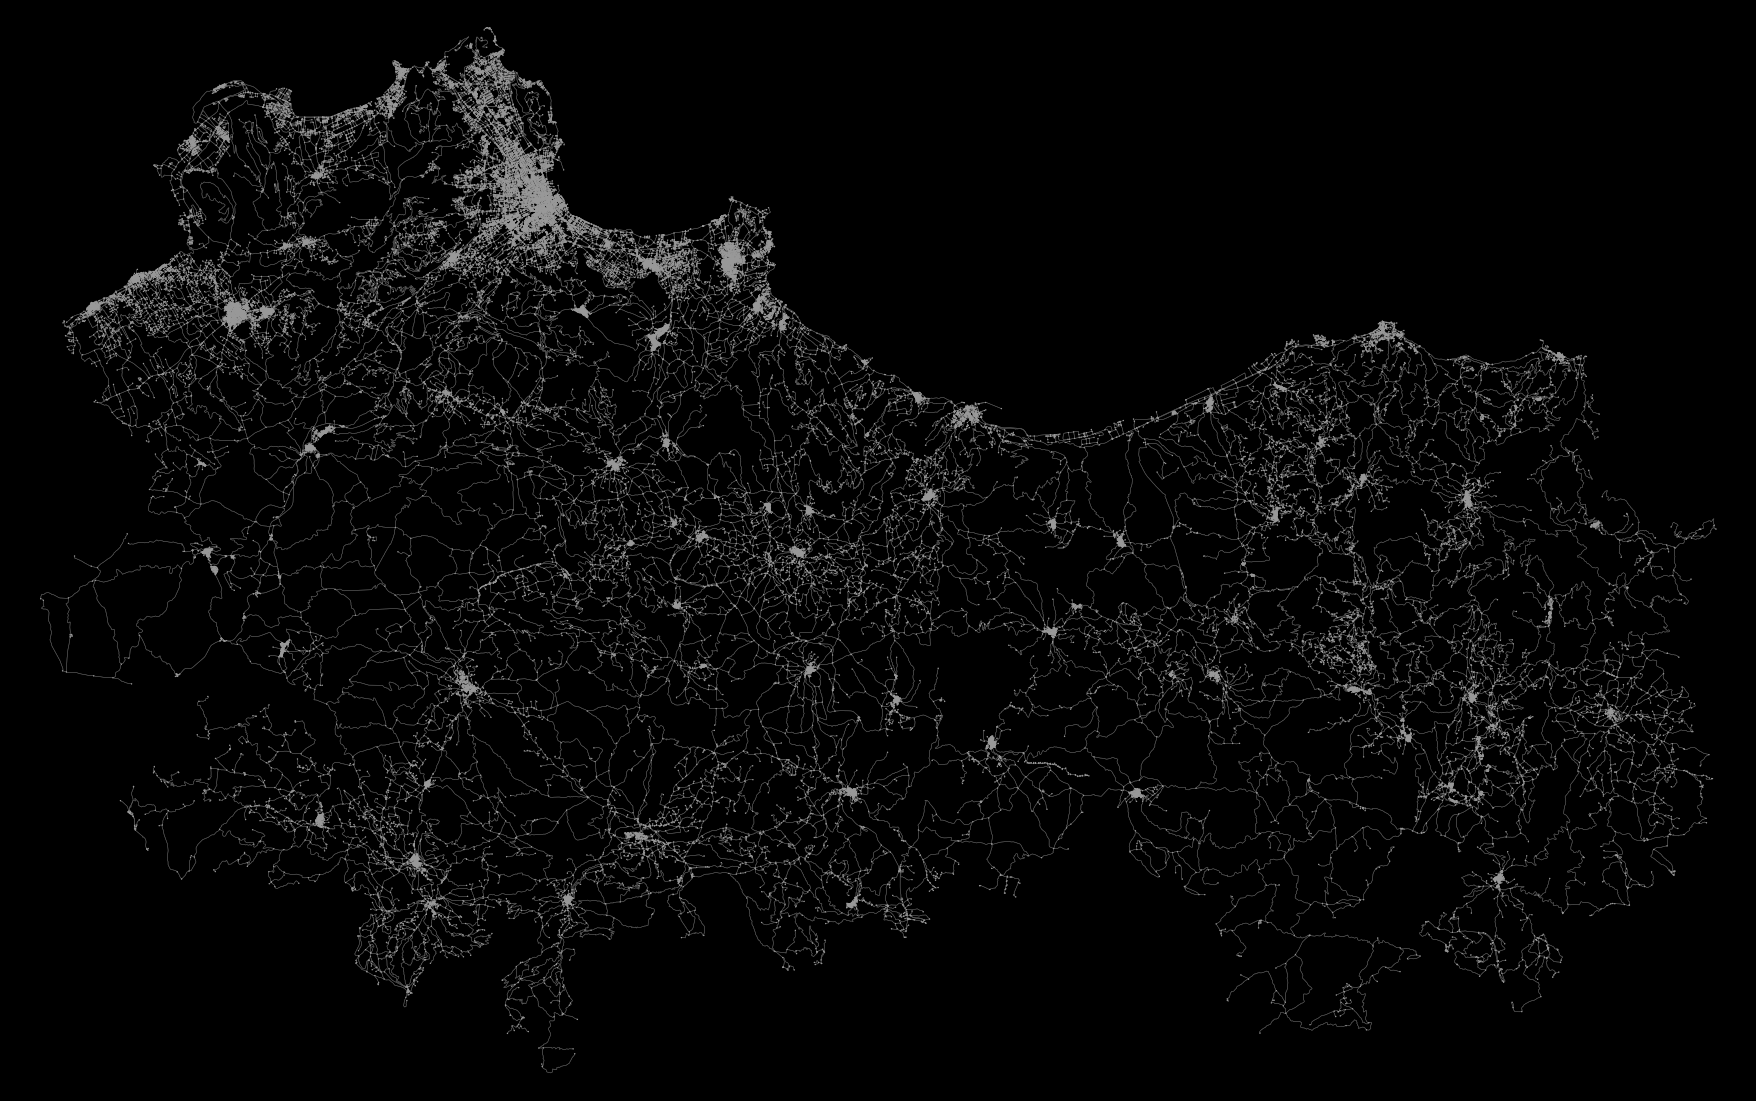

time: 6min 55s


In [18]:
# download and project a street network
G = ox.graph_from_place('Palermo, Italy', which_result=2, network_type="walk")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, fig_height=20, bgcolor='k', node_size=2, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

In [19]:
centers = {}
for i in range(0, len(popt), 6):
    lon = popt[i+1]*1000 + (np.array(polyair.center_lon)*500/meter_500).min()
    lon = lon*meter_500/500
    lat = popt[i+2]*1000 + (np.array(polyair.center_lat)*500/meter_500).min()
    lat = lat*meter_500/500
    centers['center_node_{}'.format(i//6+1)] = ox.get_nearest_node(G, (lat,lon))

centers

{'center_node_1': 1004221372,
 'center_node_2': 996023146,
 'center_node_3': 3714003413}

time: 999 ms


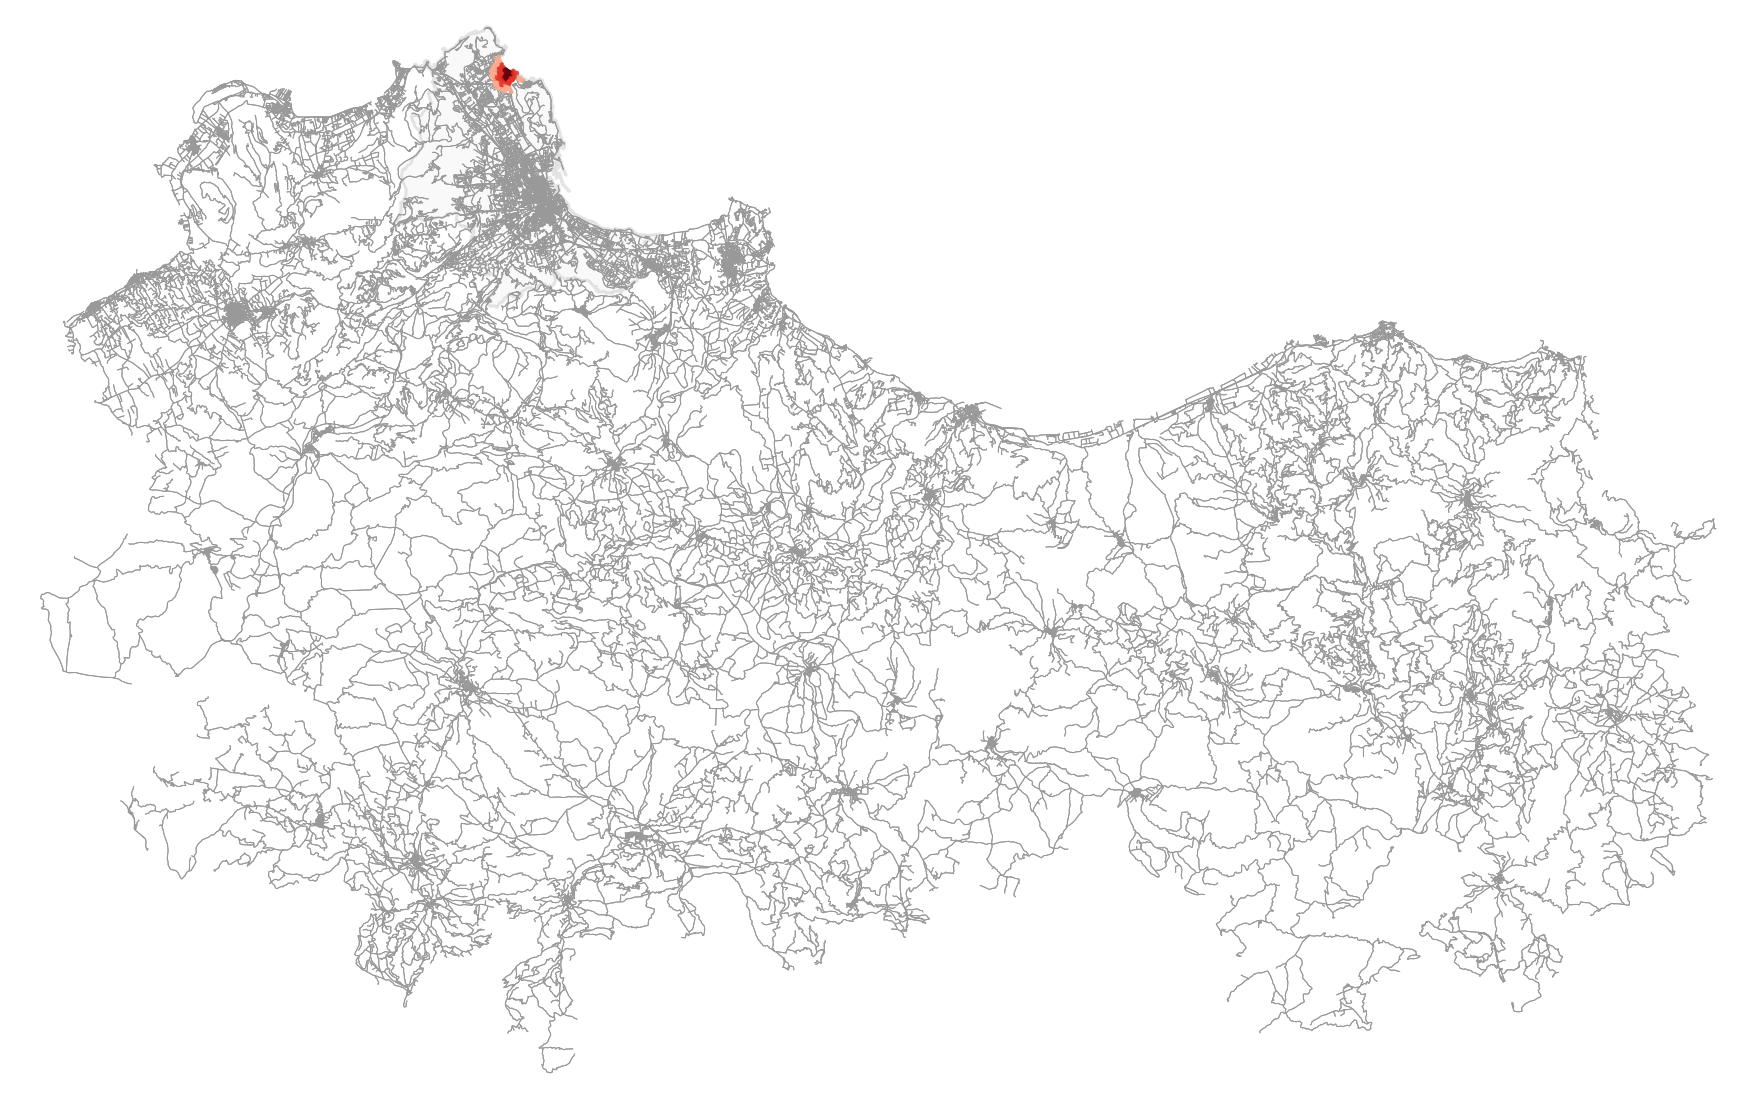

time: 48 s


In [20]:
import networkx as nx
#center_node = ox.get_nearest_node(G, (popt[8],popt[7]))
center_node = centers['center_node_1']
# list of distances from center
dists = np.arange(500, 2000, 500)
dists

# get one color for each isochrone
iso_colors = ox.get_colors(n=len(dists), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for dist, color in zip(sorted(dists, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=dist, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=20,show=False, close=False, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)
plt.close()
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in city['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)
            
fig

971
971 301
Number of cells with price above 5th percentile:  301



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes


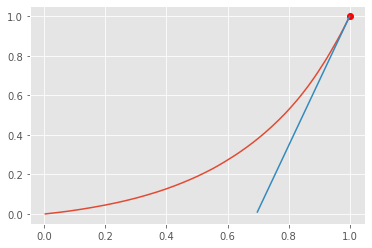

Loubar price:  22.583637021029954
Average price:  18.081289476143546
average city distance:  6147.750894540426
eta =  0.8841435007903967
time: 5.96 s


In [21]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))



mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)
    
print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True

  
if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No") 
    
    
L1= L
F1 = np.arange(1, len(L1)+1)/len(L1)

L1 = (L1 - L1.min())/(L1.max()-L1.min())

from scipy import interpolate
tck = interpolate.splrep(F1,L1)
x0_1 =1
y0_1 = interpolate.splev(x0_1,tck)
dydx = interpolate.splev(x0_1,tck,der=1)
tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
plt.plot(F1, L1)
plt.plot(x0_1,y0_1, "or")
plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
plt.show()

indlist = poly_prices.index.tolist()

loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

print('Loubar price: ', loubar_val)
print('Average price: ', np.mean(vals_cut))

if loubar_val > np.mean(vals_cut):
    loubar_keys = keys[vals_cut>loubar_val]
else:
    loubar_keys = keys[vals_cut>np.mean(vals_cut)]
#loubar_keys = keys[vals_cut>loubar_val]
dist_mat = mat[keys.reshape(-1,1), keys]

total_dist = dist_mat.sum()
dist_corr = dist_mat[dist_mat>0]

loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]
loubar_dist = loubar_dist_mat.sum()

loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
eta_loubar = loubar_dist_corr.mean()/dist_corr.mean()

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

avg_dist_meters = (dist_corr.mean()/0.00899928)*1000
print('average city distance: ', avg_dist_meters)
print('eta = ', eta_loubar)

In [22]:
pickle_in = open("City_spreading_index.pickle","rb")
spreading_index_dict = pickle.load(pickle_in)
#spreading_index_dict = {}
spreading_index_dict['Palermo'] = eta_loubar


pickle_out = open("City_spreading_index.pickle","wb")
pickle.dump(spreading_index_dict, pickle_out)
pickle_out.close()

spreading_index_dict

{'Paris': 0.7251609142253275,
 'Amsterdam': 0.6513935879350918,
 'Stockholm': 0.6839327295656318,
 'Arezzo': 0.5574311537992848,
 'Berlin': 0.7499866909236614,
 'Bordeaux': 0.5818334466519048,
 'Denver': 0.6312111392217781,
 'Edinburgh': 0.6813298654934006,
 'Lyon': 0.6138305864151811,
 'Madrid': 0.6426066210787698,
 'Buenos_Aires': 0.8337988194080271,
 'Palermo': 0.8841435007903967,
 'Los_Angeles': 0.7805422765911936,
 'Beijing': 0.6425383574699105,
 'Florence': 0.5049117106731263,
 'Moscow': 0.6925493573699144,
 'Porto': 0.7058843952576399,
 'Prague': 0.5522963433539414,
 'Reykjavik': 0.8276260142343259,
 'Riga': 0.6850021296374689,
 'Rome': 0.5803964773671335,
 'Seoul': 0.8924742030382572,
 'Siena': 0.5646389917673048,
 'Sydney': 0.7909301400958108,
 'Tallin': 0.5690189423395199,
 'Treviso': 0.5345662066021125,
 'Valencia': 0.6956994914059091,
 'Venezia': 0.656650370883064,
 'Verona': 0.5707647012625697,
 'Vicenza': 0.5117751186840898,
 'Vienna': 0.6189242538490607,
 'Wellington': 0

time: 16 ms


In [23]:
pickle_in = open("avg_distances_dict.pickle","rb")
avg_distances_dict = pickle.load(pickle_in)
#avg_distances_dict = {}
avg_distances_dict['Palermo'] = avg_dist_meters


pickle_out = open("avg_distances_dict.pickle","wb")
pickle.dump(avg_distances_dict, pickle_out)
pickle_out.close()

avg_distances_dict

{'Venezia': 2398.636425932576,
 'Verona': 3141.8502884813342,
 'Vicenza': 1988.2224372858566,
 'Vienna': 5125.89366602888,
 'Wellington': 2806.4963410749997,
 'Zurich': 2068.4583585914684,
 'Aarhus': 2857.919349359045,
 'Milan': 6008.128043000454,
 'Busan': 7348.804402235624,
 'Valencia': 4090.433301180094,
 'Bologna': 2104.4589605649485,
 'Barcelona': 4218.232625020259,
 'Bremen': 3495.925661234734,
 'Brno': 2231.9772664038364,
 'Budapest': 3463.3335339061914,
 'Dublin': 4260.485994007804,
 'Boston': 5610.60832524716,
 'Rio': 8357.334811118957,
 'NY': 8563.096975538809,
 'Ottawa': 2220.3476963993976,
 'Nashville': 5606.900406329212,
 'New_Orleans': 5048.047130029565,
 'Shanghai': 5452.583570486633,
 'Portland': 5406.388840795854,
 'Amsterdam': 7020.480387015727,
 'Arezzo': 1662.0178383704194,
 'Beijing': 6586.560663166117,
 'Berlin': 8495.253652229821,
 'Bordeaux': 3886.5511701192345,
 'Buenos_Aires': 4620.5517793826875,
 'Denver': 3896.3436245957214,
 'Edinburgh': 3747.7817698651684,

time: 9 ms


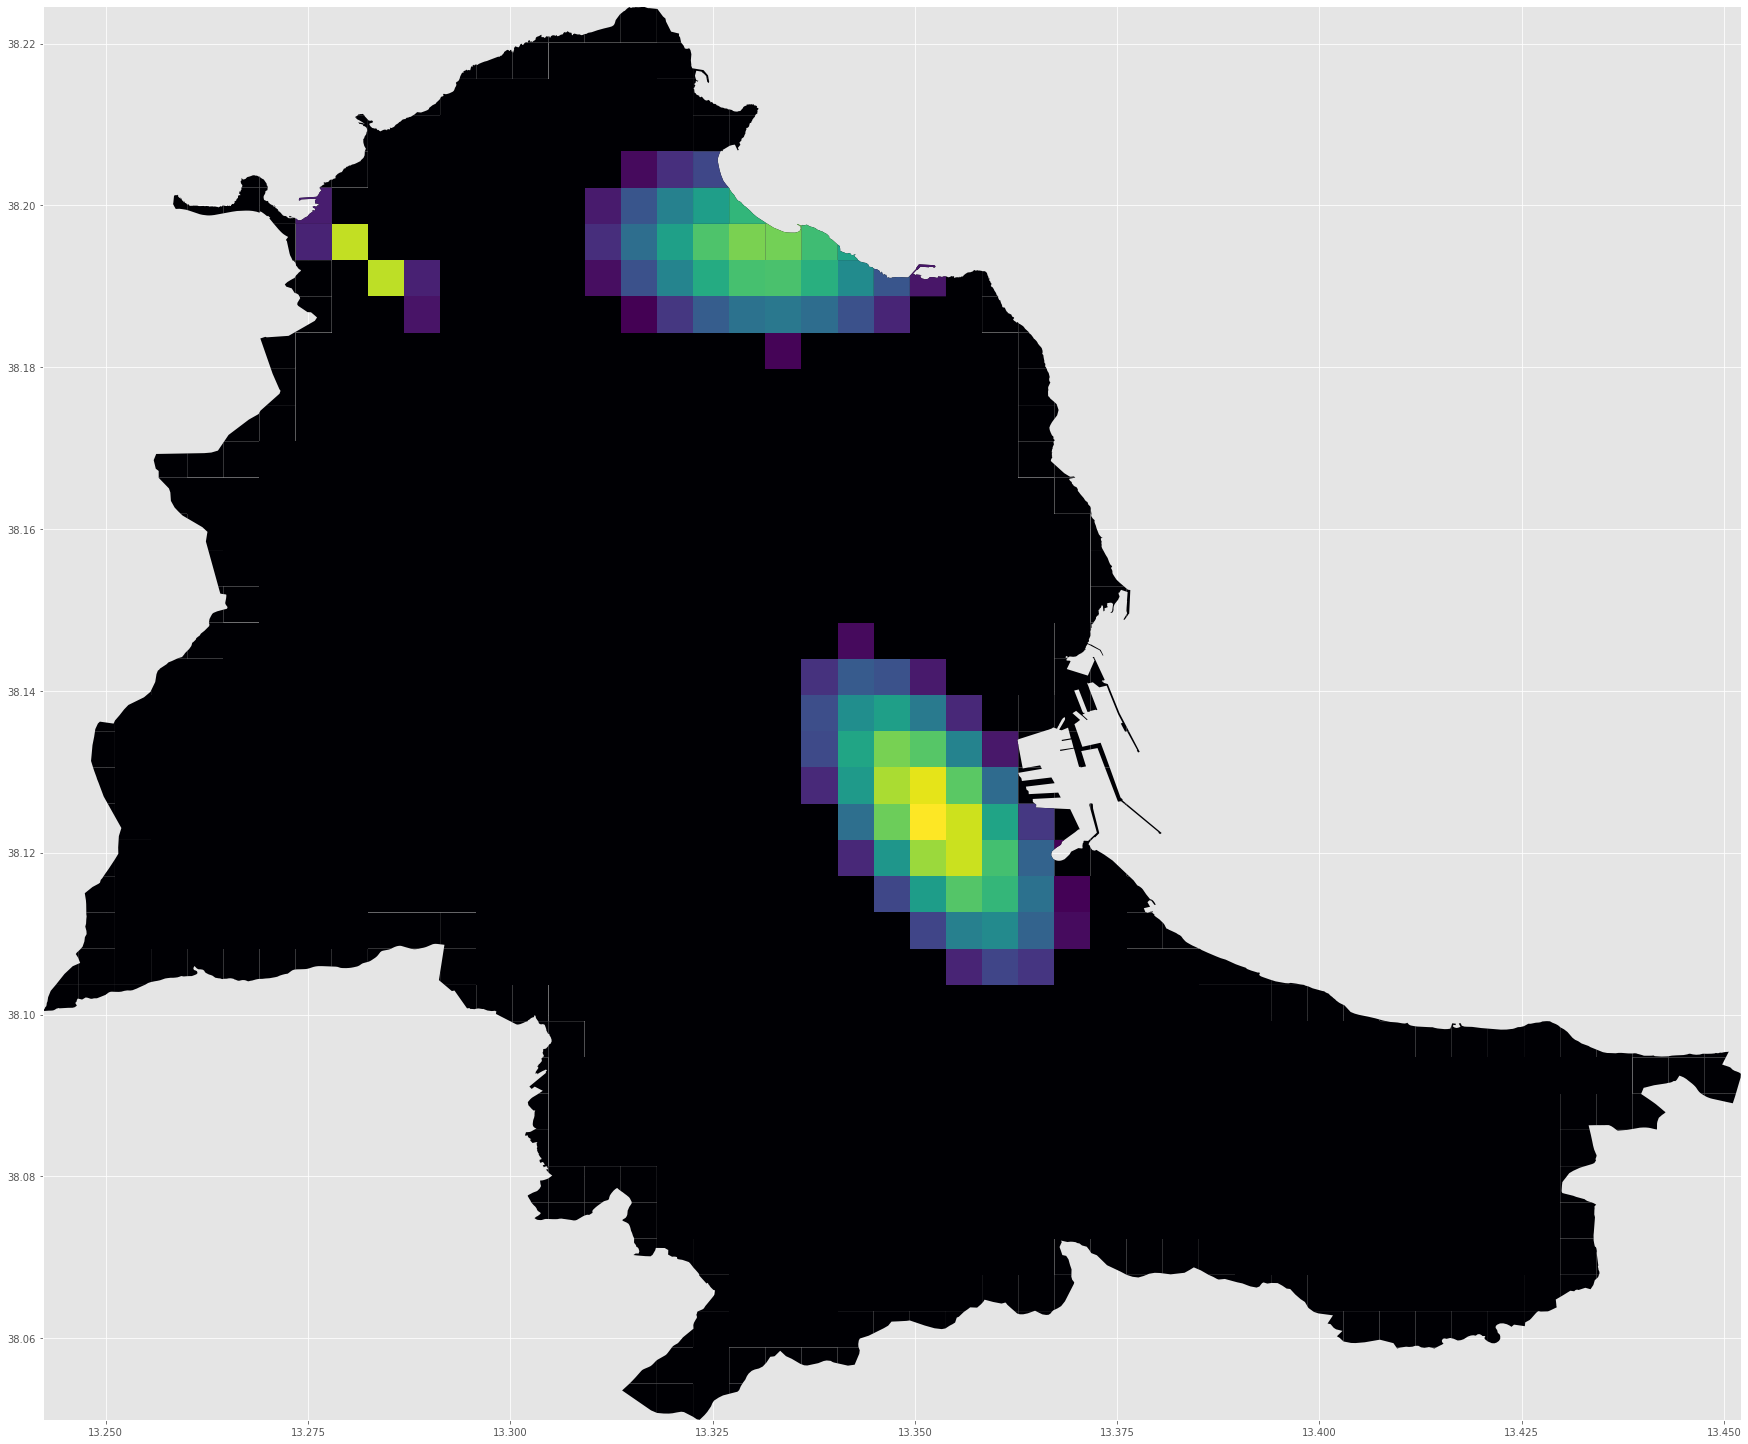

time: 1.87 s


In [24]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
#polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
poly_prices[poly_prices.index.isin(loubar_keys)].plot(ax=ax, column='zpred')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [25]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    
print(len(keys))
vals = np.array(vals)
keys = np.array(keys)
keys = keys[vals>=0.01*vals.max()]
print(len(keys))

indlist = poly_prices.index.tolist()
mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)

print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True


if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No")

971
431



[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.00447879 0.00895758]
 [0.         0.         0.         ... 0.         0.         0.00447879]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Yes
time: 11.3 s


971


C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning:

Mean of empty slice.

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in true_divide



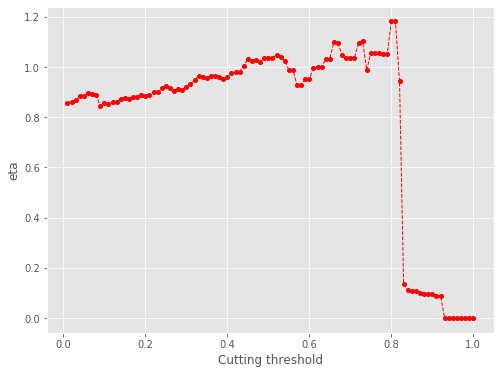

time: 573 ms


In [26]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_cut = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    #print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    #print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    
    
        
    L1= L
    F1 = np.arange(1, len(L1)+1)/len(L1)

    L1 = (L1 - L1.min())/(L1.max()-L1.min())
    

    loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

    #print('Loubar price: ', loubar_val)
    #print('Average price: ', np.mean(vals_cut))
    
    
    loubar_keys = keys[vals_cut>loubar_val]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas_cut.append(eta)
    #print('eta = ', eta)
etas_cut = np.array(etas_cut)
etas_cut = np.where(np.isnan(etas_cut), 0, etas_cut)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perc_vals, etas_cut, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Cutting threshold")
plt.ylabel("eta")
plt.show()

In [27]:
pickle_in = open("etas_cut_dict.pickle","rb")
etas_cut_dict = pickle.load(pickle_in)
#etas_cut_dict = {}
etas_cut_dict['Palermo'] = etas_cut


pickle_out = open("etas_cut_dict.pickle","wb")
pickle.dump(etas_cut_dict, pickle_out)
pickle_out.close()

etas_cut_dict

{'Boston': array([0.69697859, 0.70601119, 0.71142664, 0.72735905, 0.71723297,
        0.69152614, 0.68969459, 0.69338651, 0.68627389, 0.68571239,
        0.68565242, 0.66080855, 0.68568495, 0.66662135, 0.65169235,
        0.66853925, 0.64080339, 0.6392735 , 0.64870117, 0.66369008,
        0.64936606, 0.65513408, 0.65817401, 0.54708479, 0.54484174,
        0.5177247 , 0.54225619, 0.54660686, 0.55128317, 0.55836993,
        0.56571414, 0.52792612, 0.52759205, 0.55096732, 0.46941853,
        0.48021089, 0.47484233, 0.46129546, 0.46439344, 0.4699713 ,
        0.50255475, 0.51573036, 0.52765377, 0.52765377, 0.53943229,
        0.54404083, 0.54813213, 0.6100999 , 0.50092562, 0.52536404,
        0.56707558, 0.56150998, 0.61316219, 0.66467806, 0.74541769,
        0.74541769, 0.77652679, 0.74895419, 0.92876367, 0.92876367,
        0.90963119, 0.90963119, 1.05344906, 1.15130075, 1.15130075,
        1.22651104, 1.26738008, 0.62257449, 0.62257449, 0.64231201,
        0.64231201, 0.62403947, 0.6307

time: 56 ms


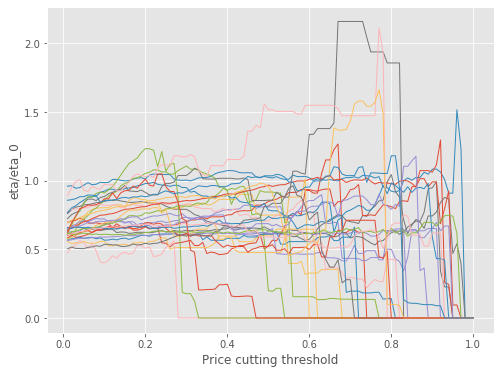

time: 503 ms


In [28]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_dict:
    #print(len(etas_cut_dict[key]))
    etas = etas_cut_dict[key]#[1:]
    #vals = etas/etas[0]
    plt.plot(np.linspace(0.01, 1, 100), etas, linestyle='-', linewidth=1)
plt.xlabel("Price cutting threshold")
plt.ylabel("eta/eta_0")
plt.show()

971 301
Number of cells with price above 5th percentile:  301


C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning:

Mean of empty slice.



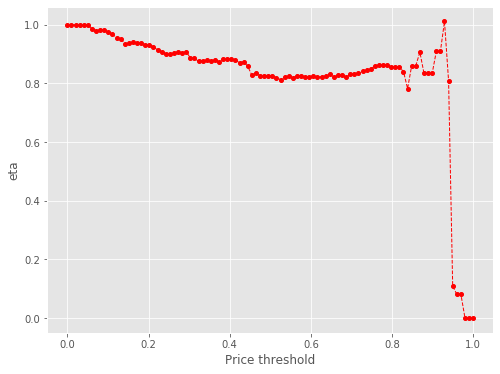

time: 689 ms


In [29]:
lval = np.linspace(0, max(vals_cut), 100)
etas = []

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)
vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

for i in tqdm_notebook(lval):
    loubar_keys = keys[vals_cut>=i]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas.append(eta)
    #print('eta = ', eta)
etas = np.array(etas)
etas = np.where(np.isnan(etas), 0, etas)
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lval, etas, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

etas_cut_threshold = etas

In [30]:
pickle_in = open("etas_cut_threshold_dict.pickle","rb")
etas_cut_threshold_dict = pickle.load(pickle_in)
#etas_cut_threshold_dict = {}
etas_cut_threshold_dict['Palermo'] = etas_cut_threshold


pickle_out = open("etas_cut_threshold_dict.pickle","wb")
pickle.dump(etas_cut_threshold_dict, pickle_out)
pickle_out.close()

etas_cut_threshold_dict

{'NY': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99991145, 0.98955316, 0.97868522, 0.96344498, 0.95205618,
        0.94615067, 0.93194961, 0.92540239, 0.92150344, 0.91822455,
        0.91569734, 0.91218202, 0.90337978, 0.898264  , 0.89376519,
        0.89441924, 0.88573077, 0.88617046, 0.87902683, 0.87195329,
        0.87101443, 0.87158631, 0.86935351, 0.86321974, 0.86053312,
        0.86079304, 0.86069179, 0.86140605, 0.85888874, 0.8617884 ,
        0.85709178, 0.8579834 , 0.85179248, 0.84947743, 0.84847717,
        0.84228408, 0.82983947, 0.82767187, 0.82334824, 0.81678545,
        0.81788964, 0.81304395, 0.807866  , 0.79902867, 0.79698224,
        0.78820712, 0.76853775, 0.76312442, 0.75071909, 0.7481045 ,
        0.73389742, 0.71700231, 0.70245218, 0.68328343, 0.67990807,
        0.66811743, 0.61552082, 0.58620924, 0.57826542, 0.57372339,
        0.55441141, 0.5326264 , 0.53706259, 0.53126932, 0.52772792,
        0.5331439 , 0.51700595, 0.49034259

time: 81 ms


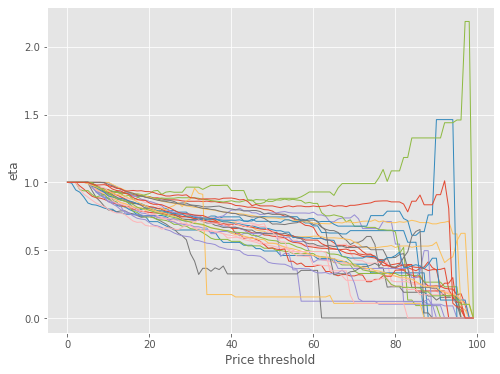

time: 470 ms


In [31]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_cut_threshold_dict:
    plt.plot(np.arange(100), etas_cut_threshold_dict[key], linestyle='-', linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning:

Mean of empty slice.



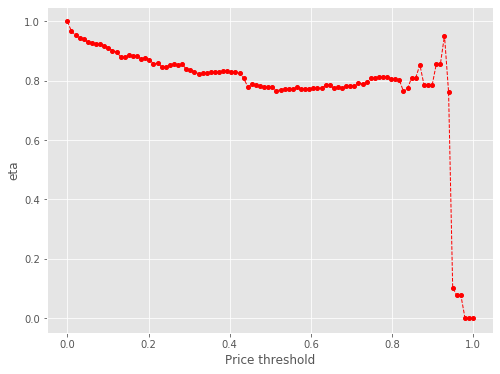

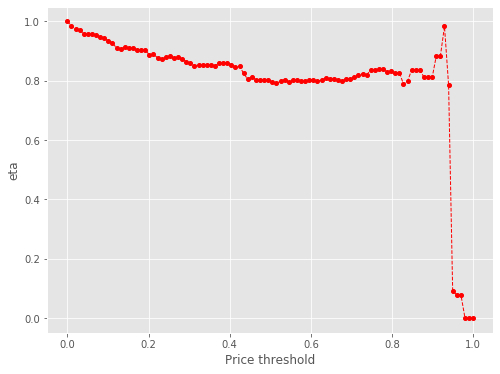

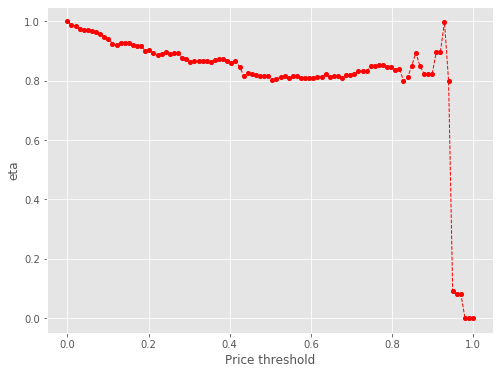

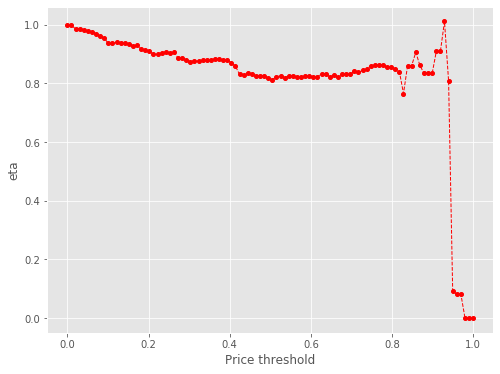

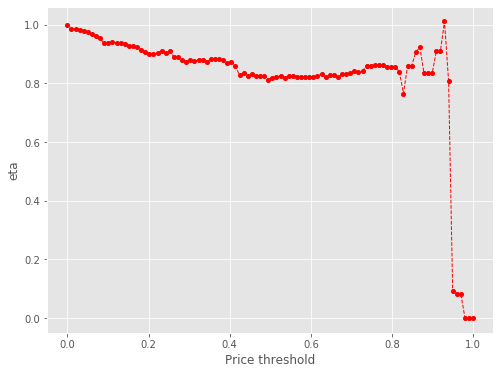

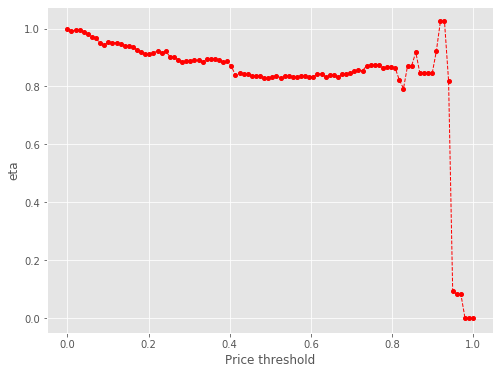

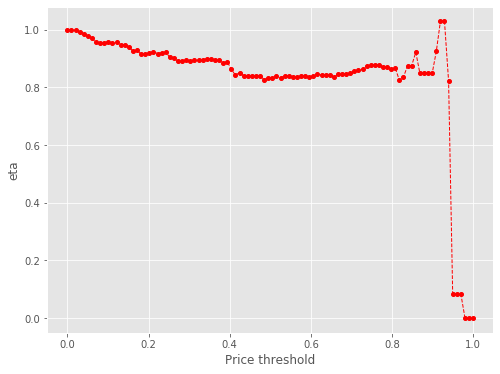

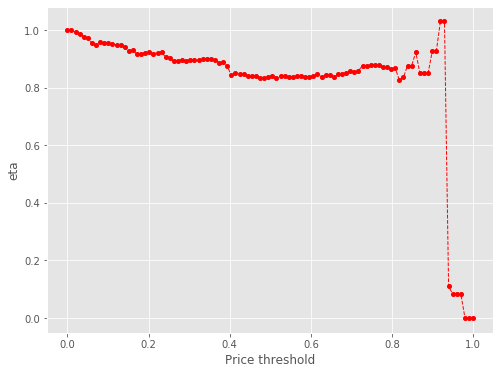

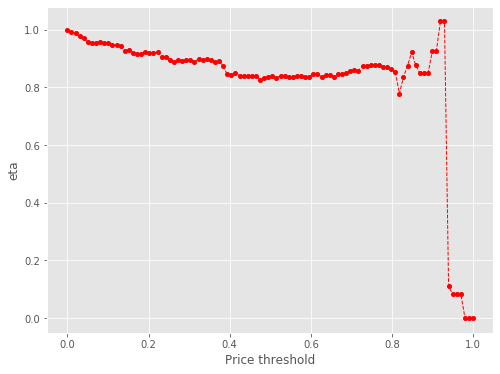

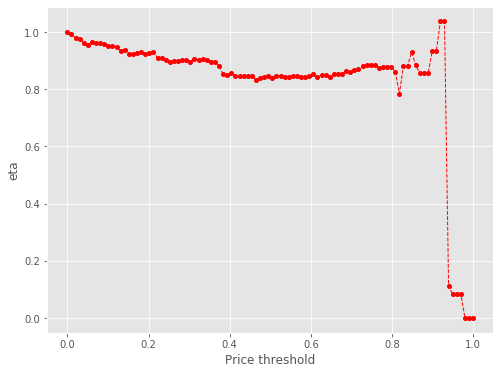

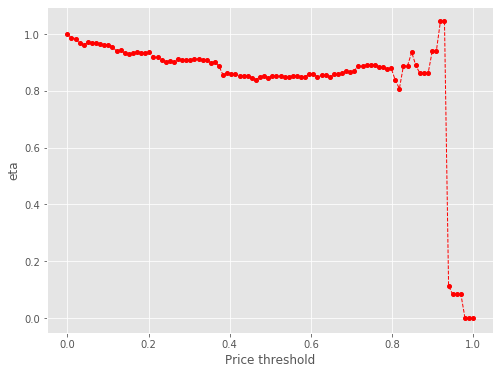

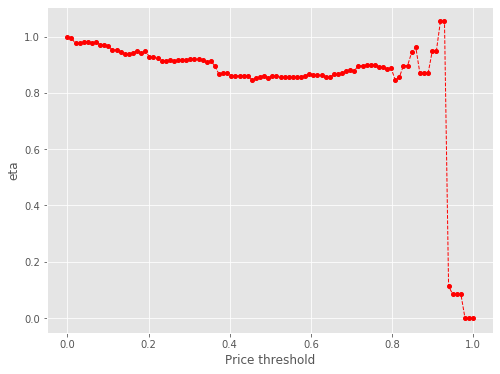

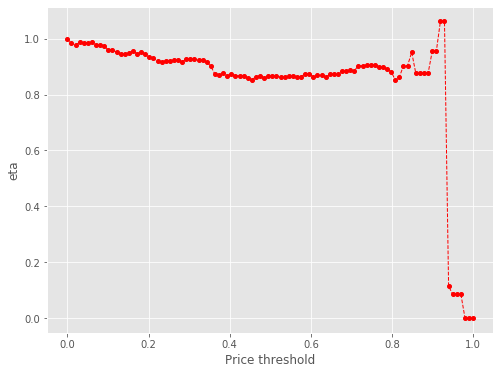

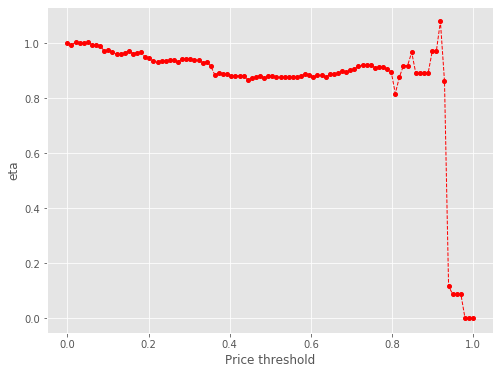

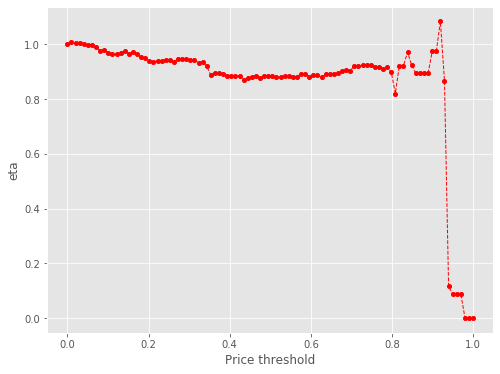

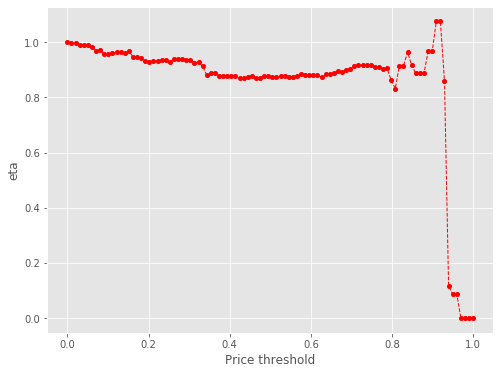

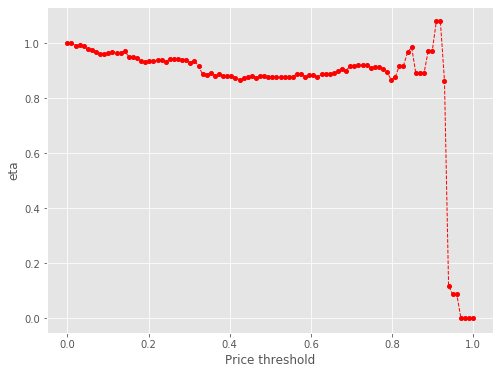

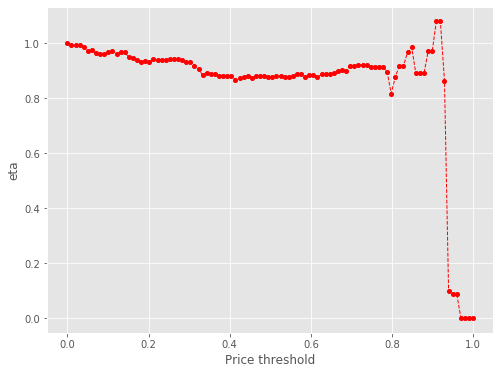

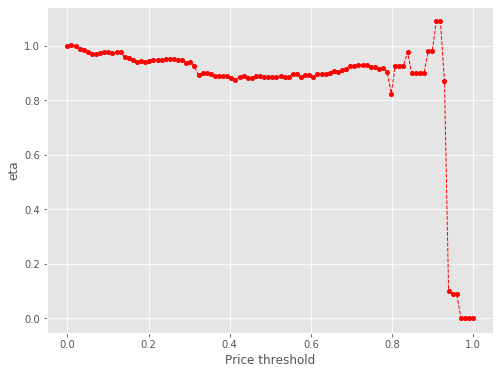

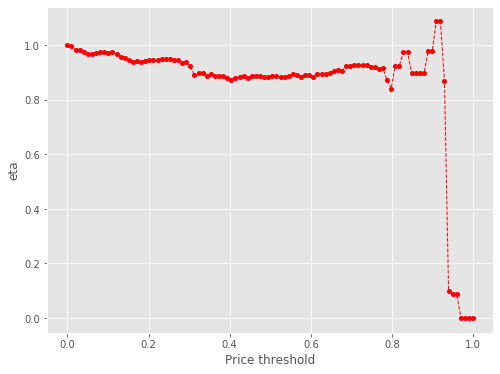

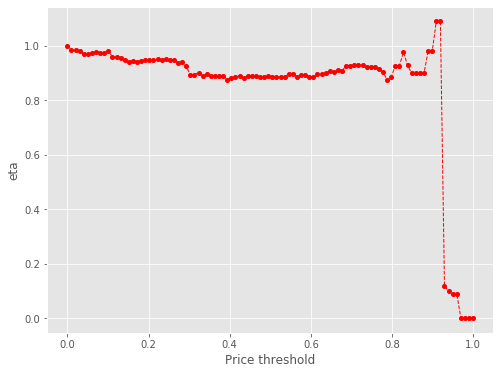

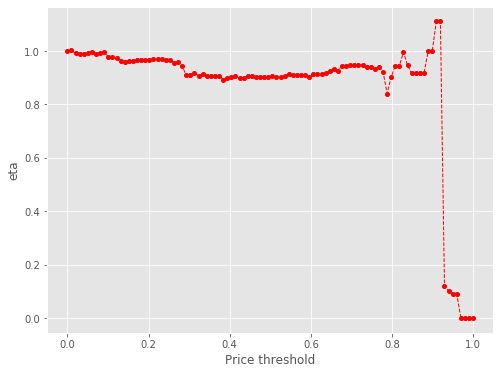

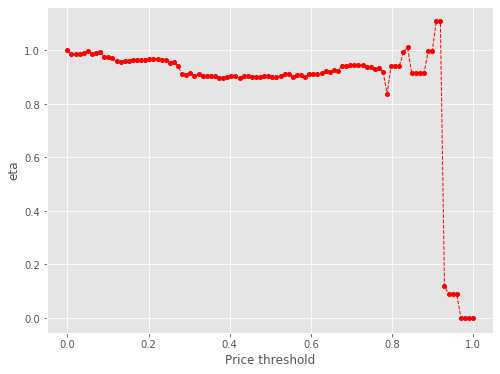

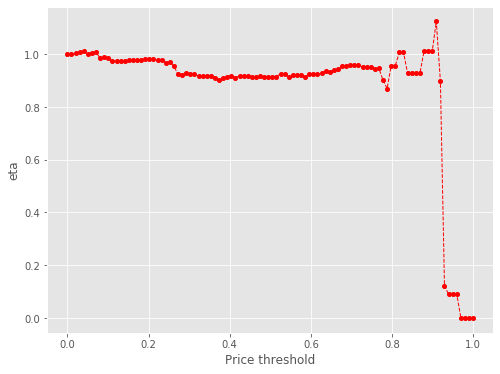

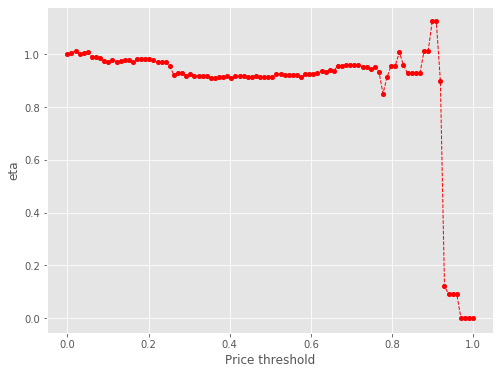

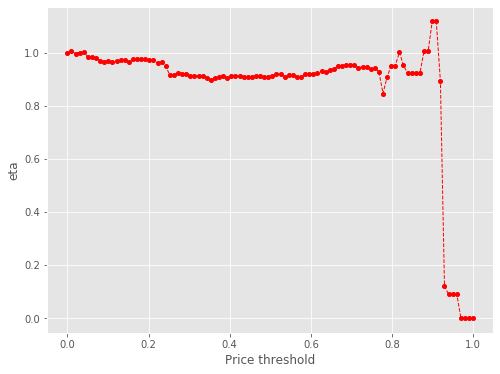

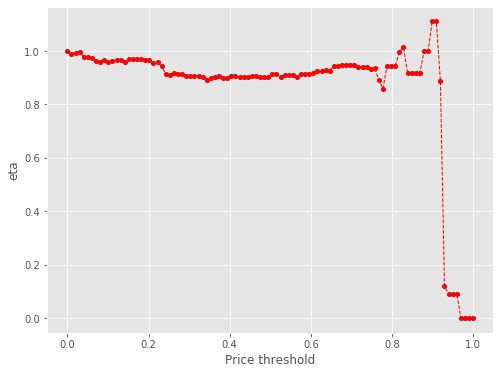

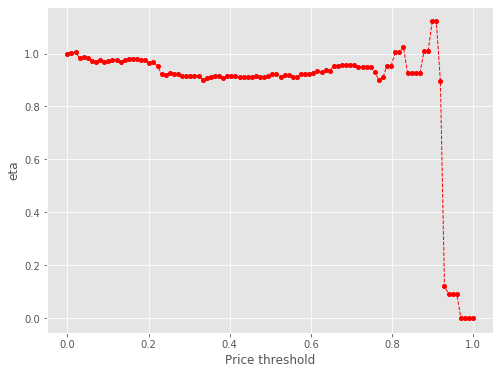

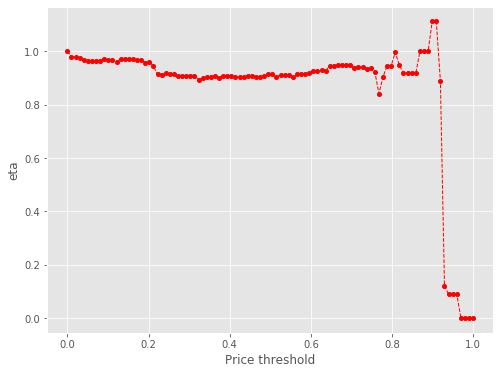

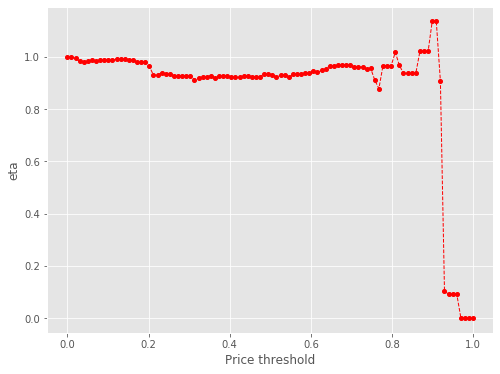

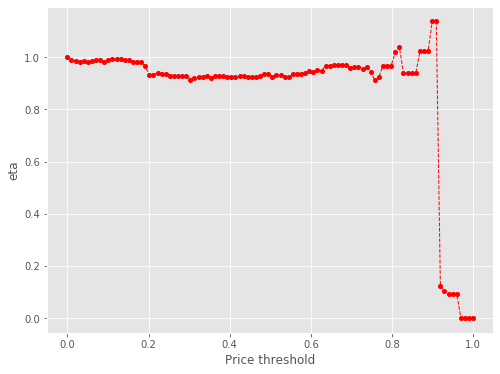

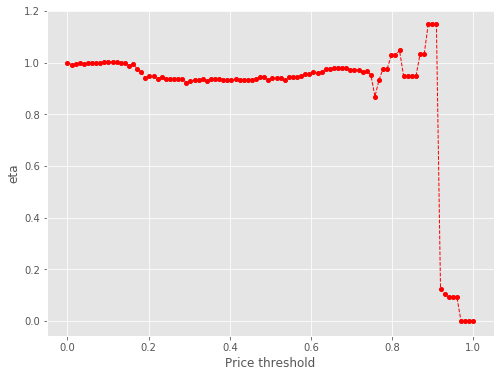

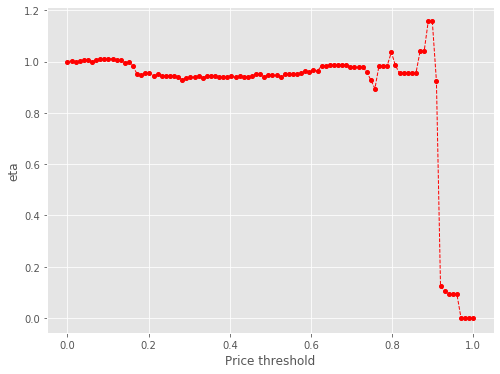

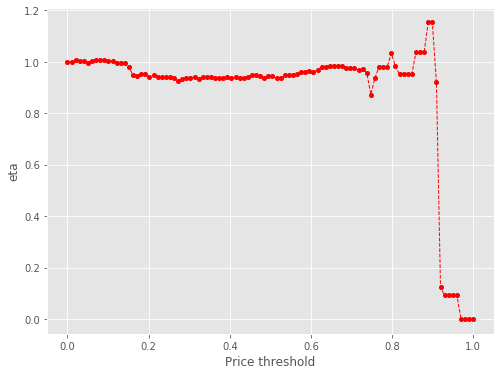

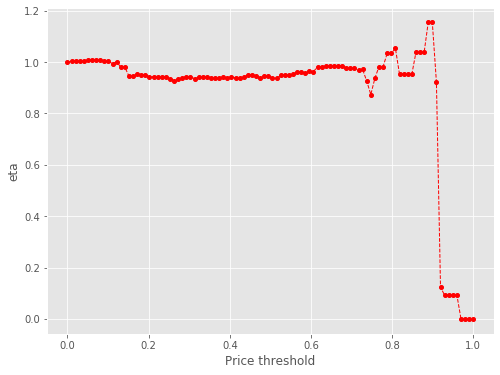

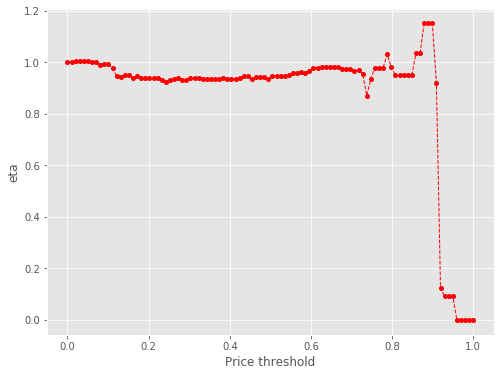

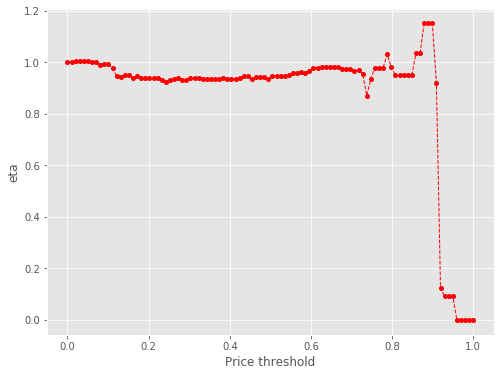

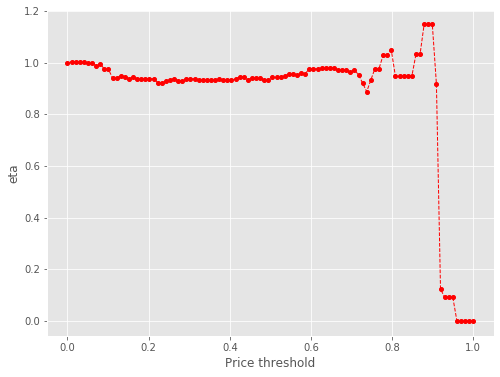

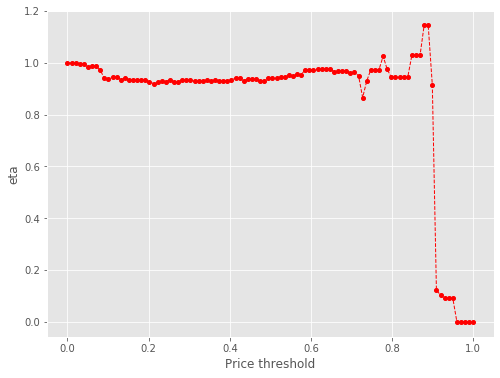

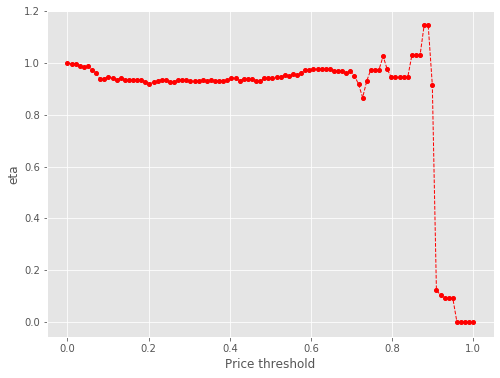

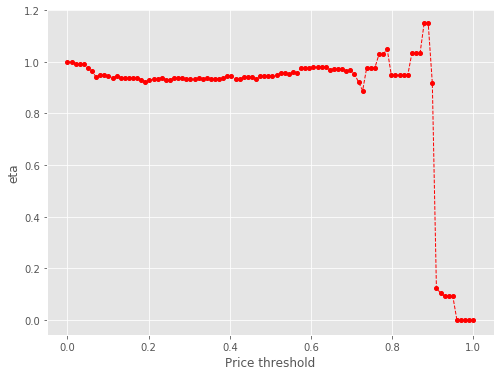

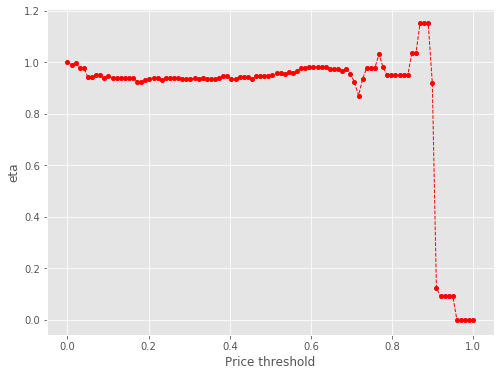

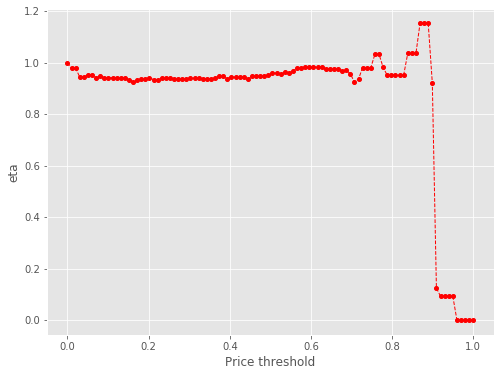

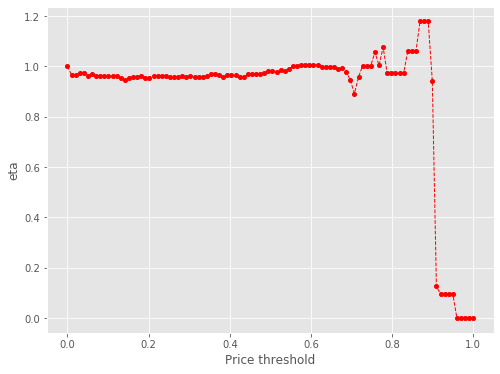

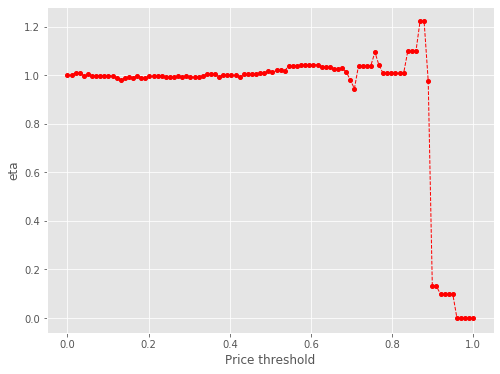

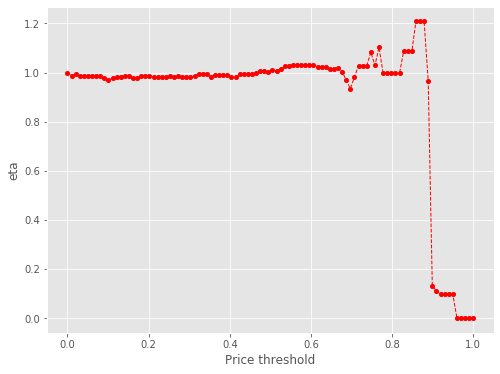

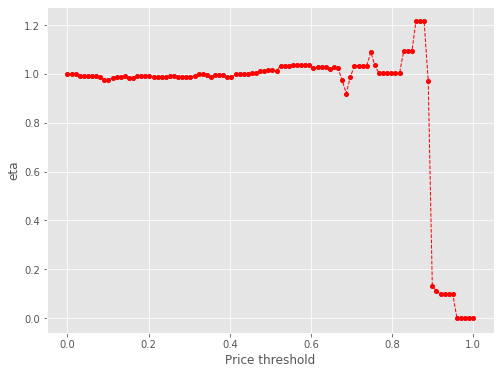

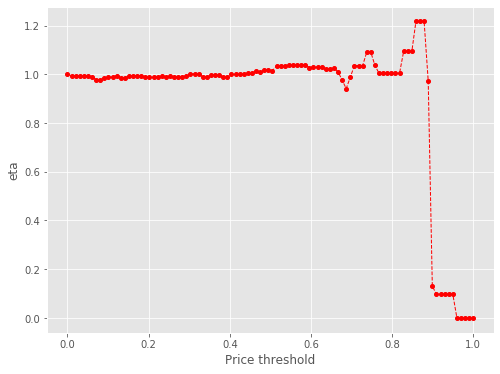

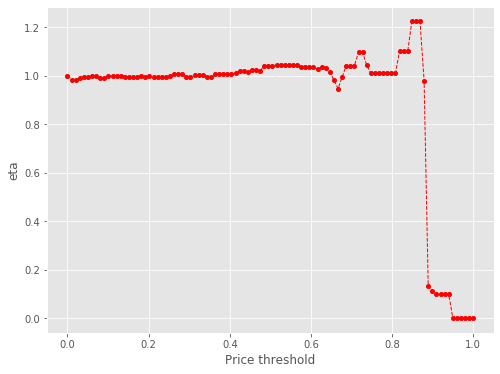

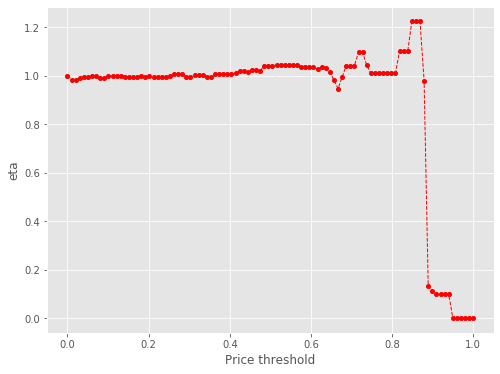

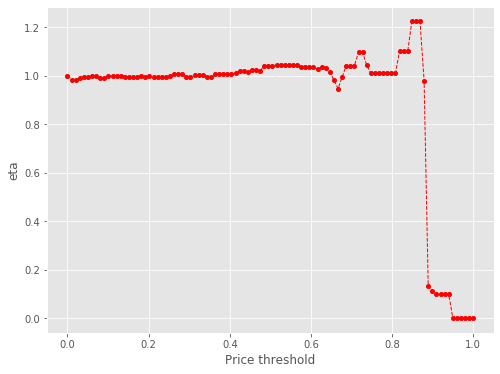

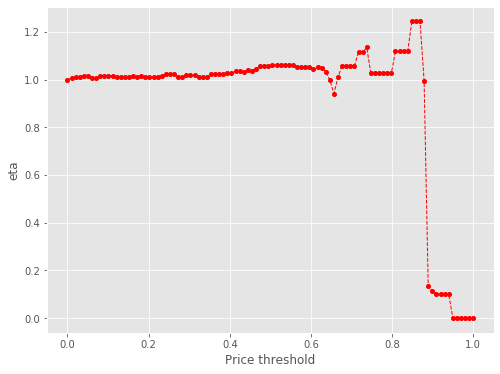

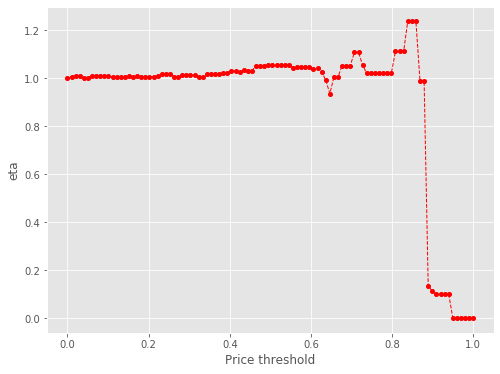

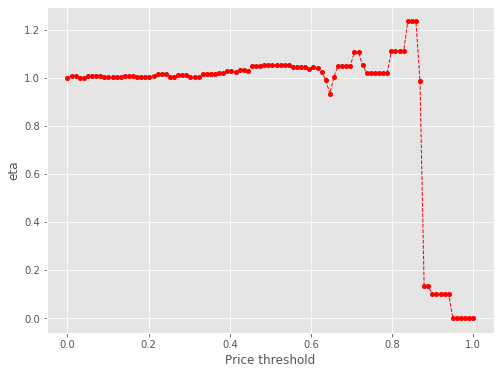

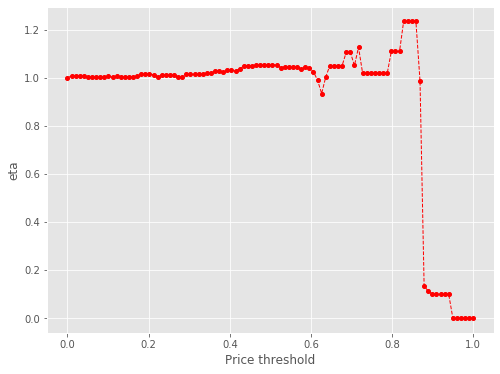

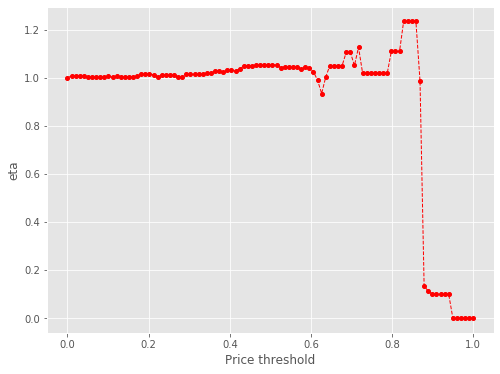

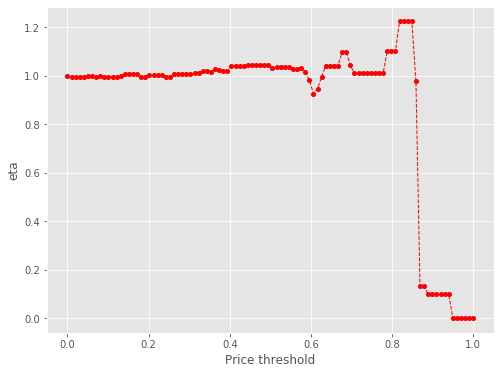

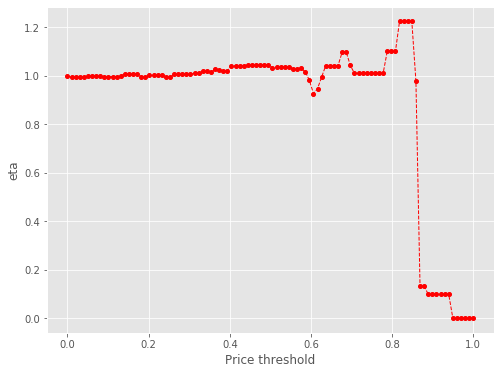

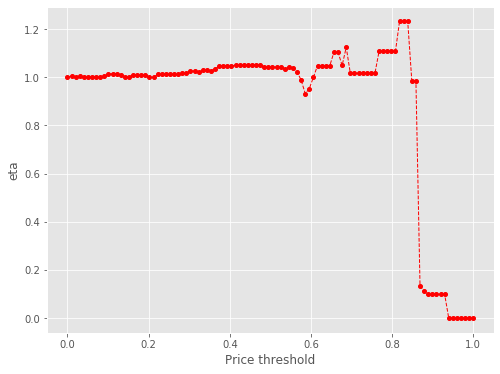

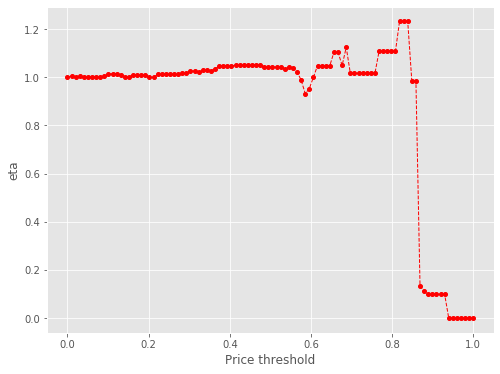

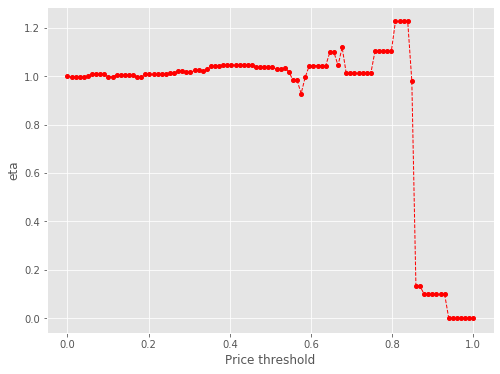

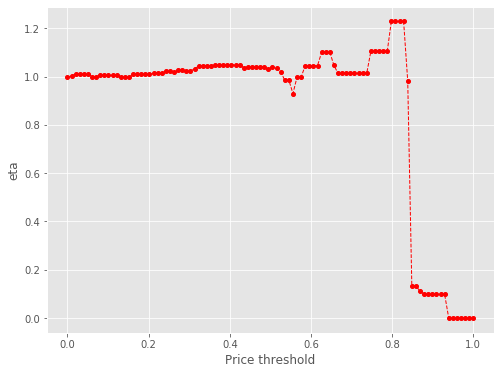

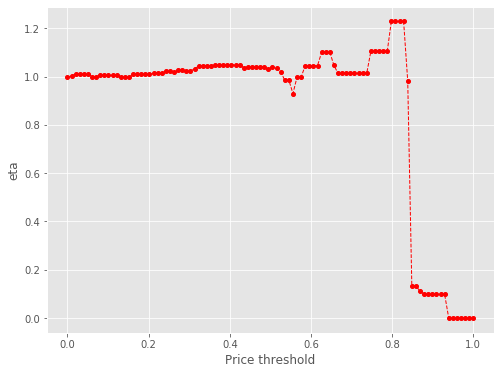

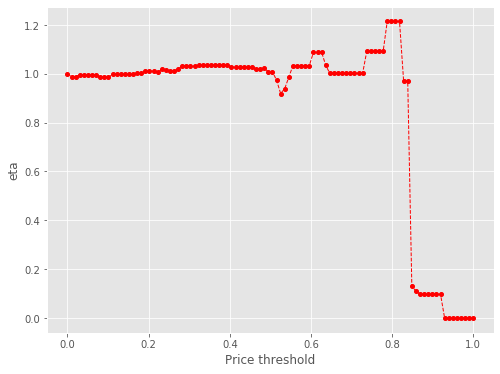

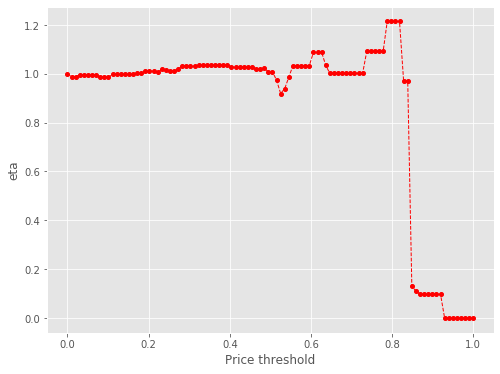

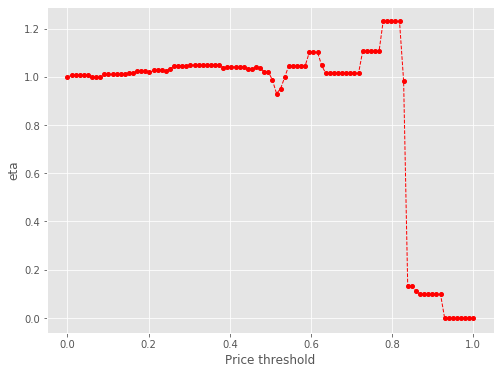

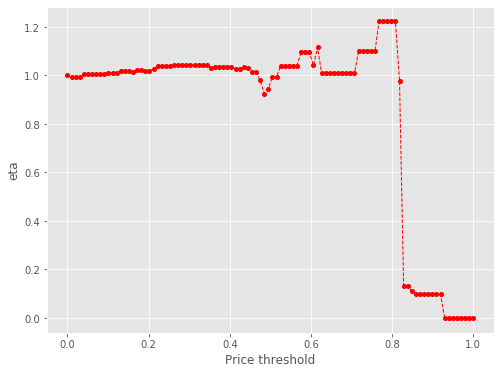

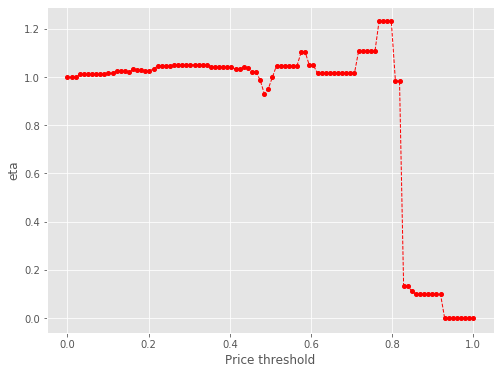

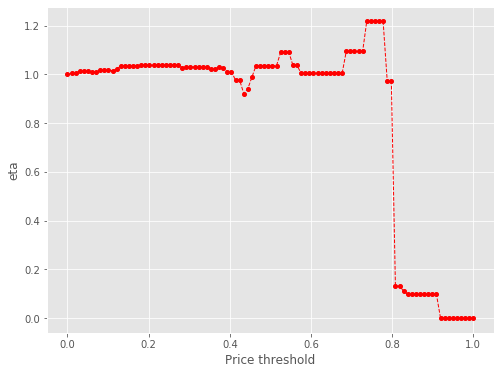

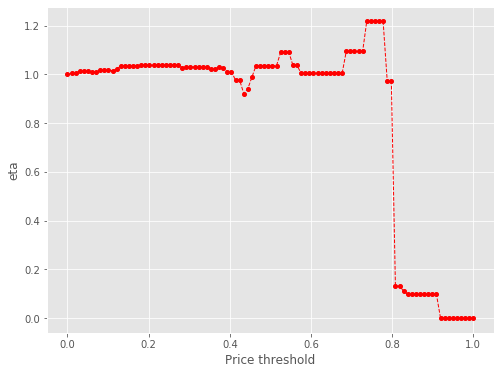

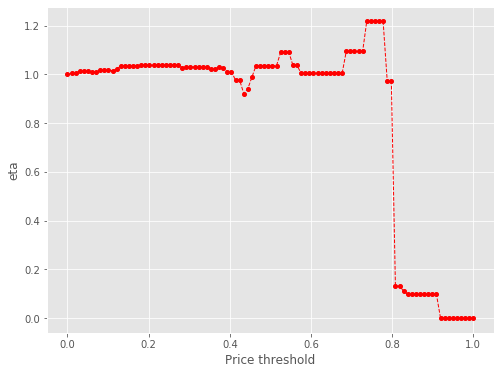

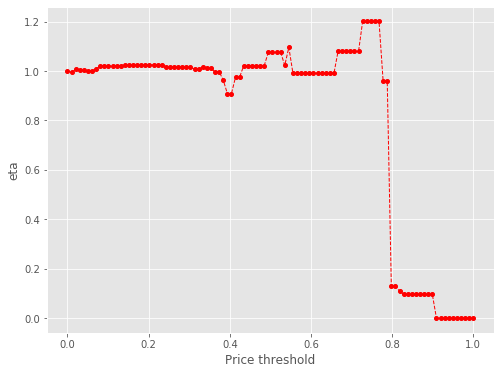

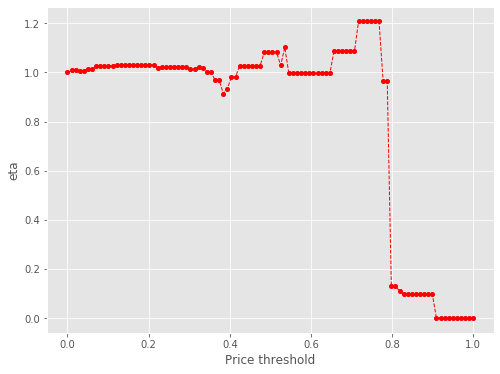

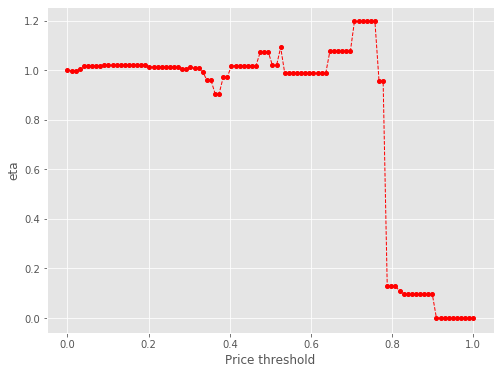

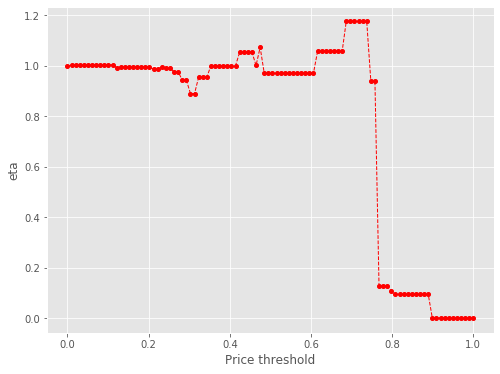

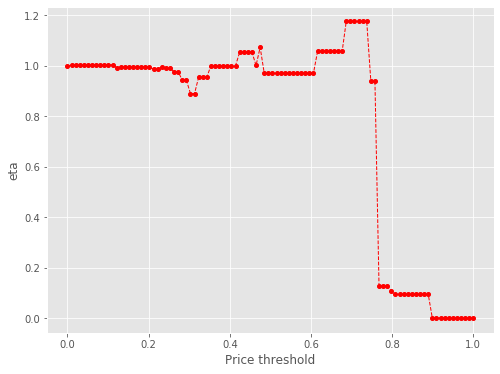

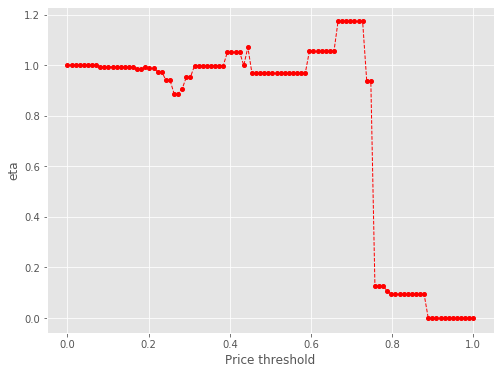

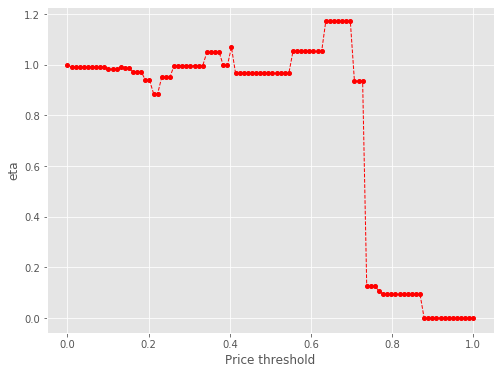

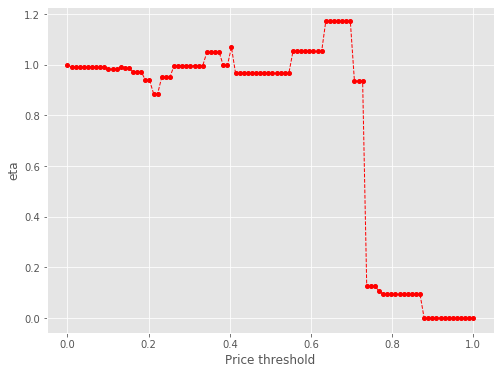

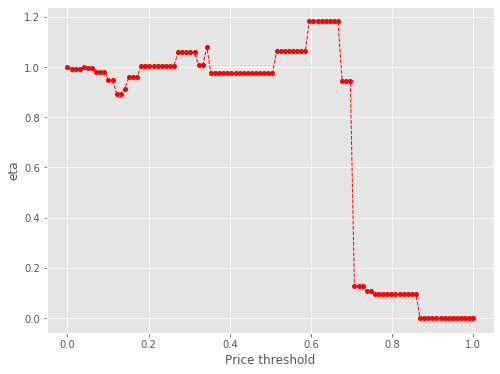

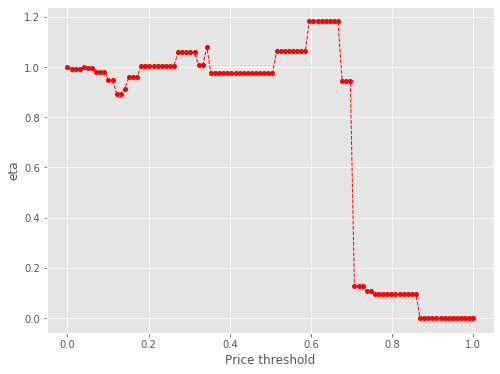

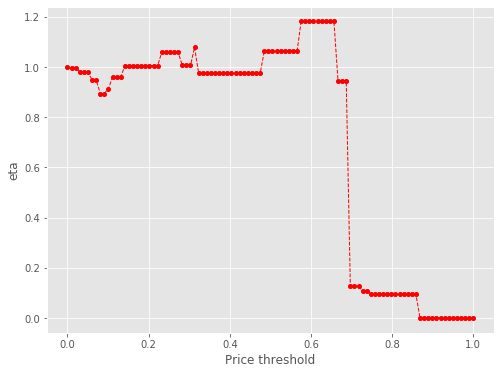

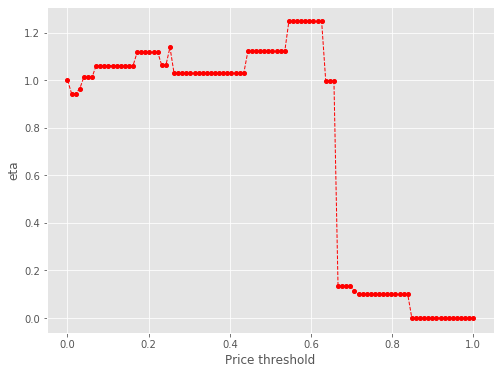

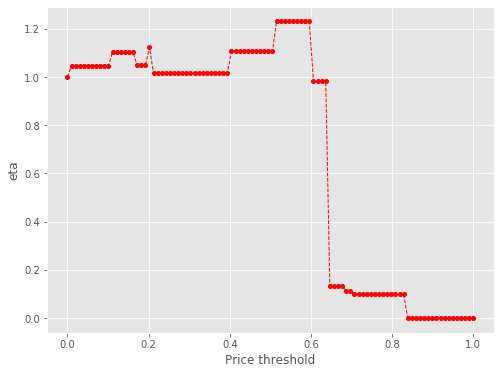

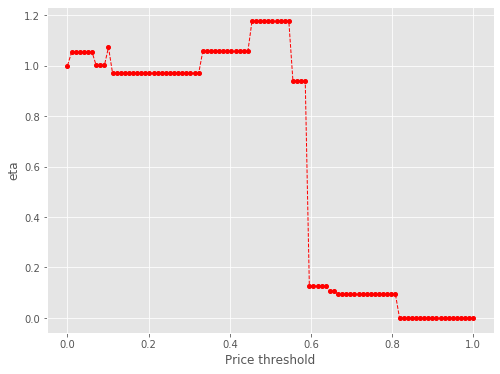

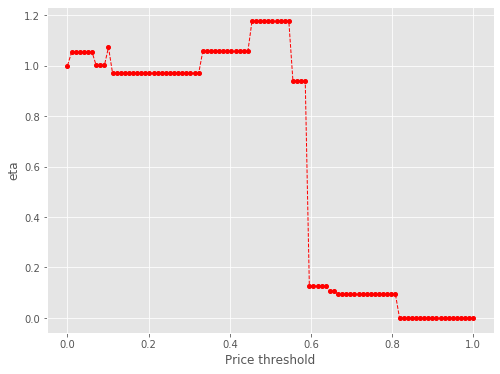

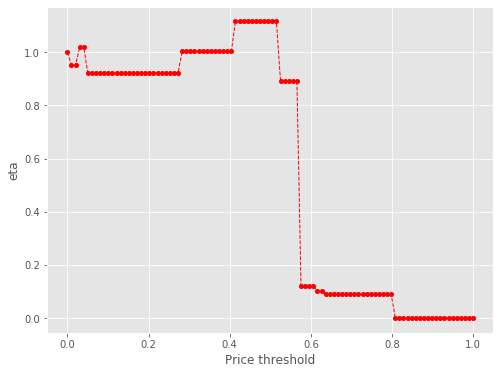

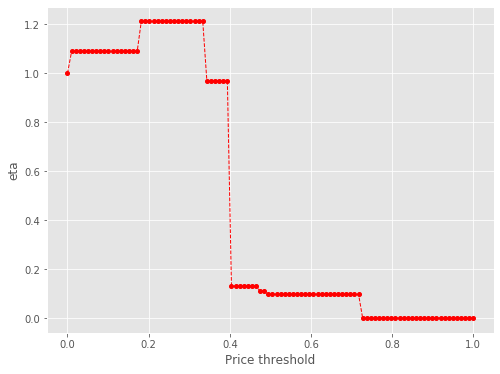

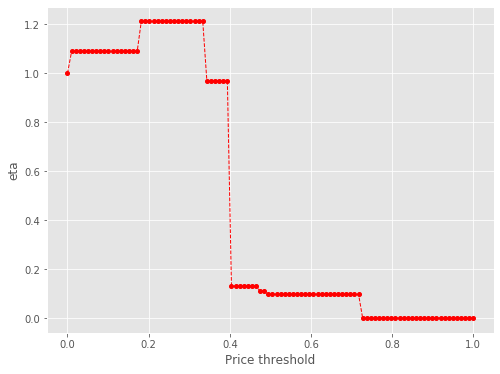

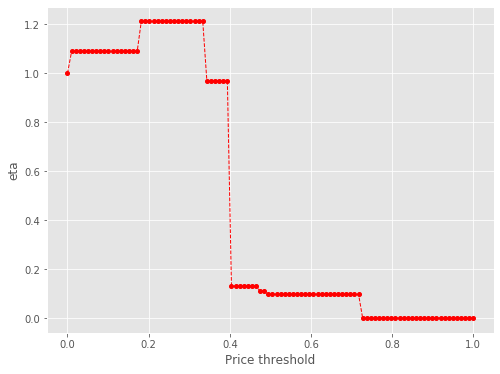

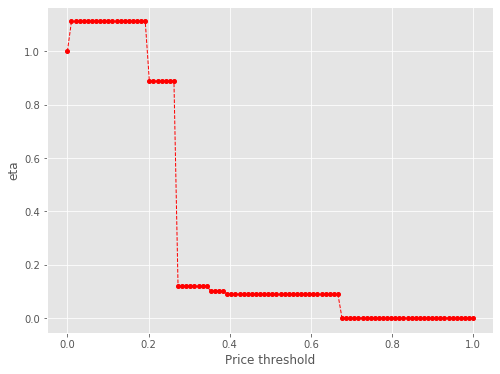

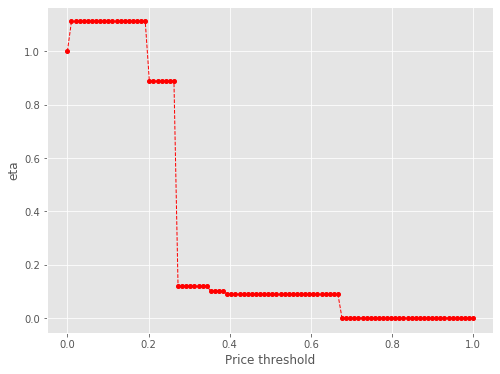

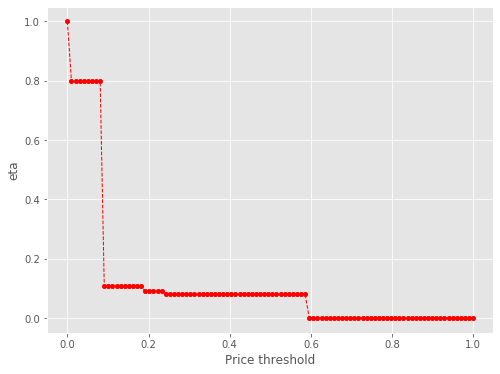

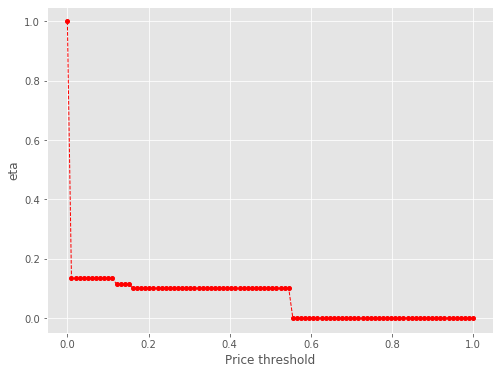

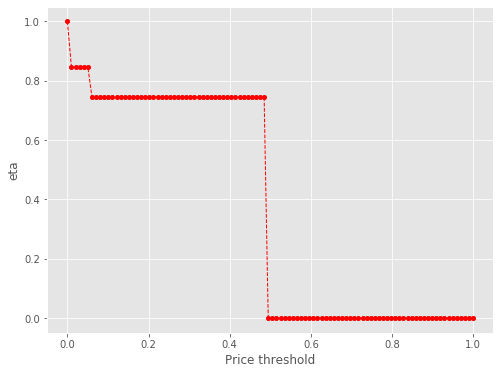

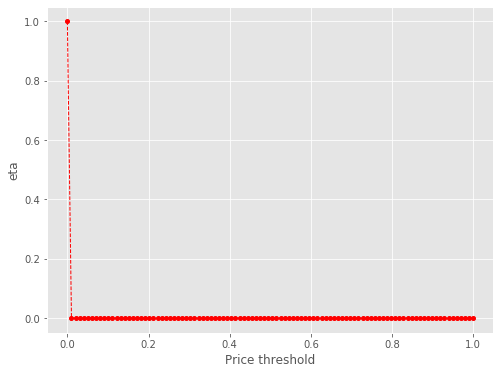

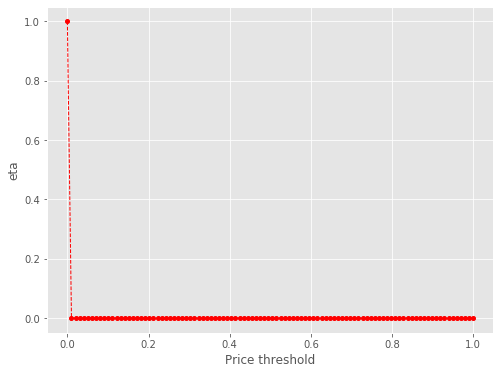

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:44: RuntimeWarning:

invalid value encountered in true_divide



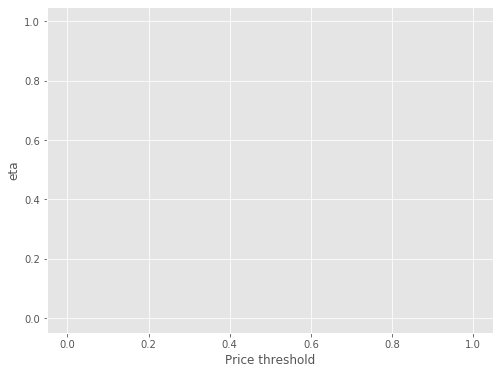

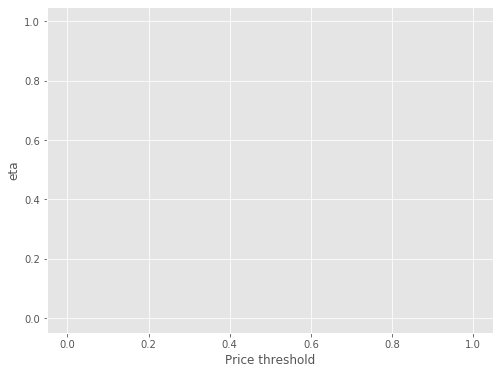

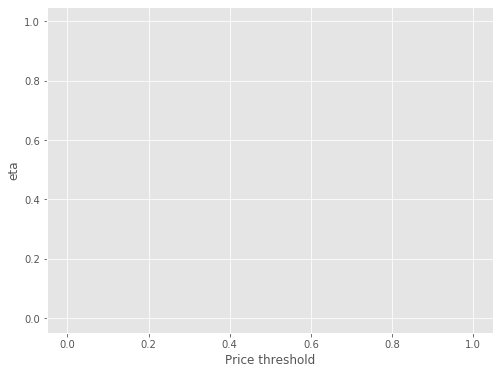


time: 41.6 s


In [32]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
#keys = np.array(keys)
keys_initial = np.array(keys)


perc_vals = np.linspace(0.01, 1, 100)
etas_2d = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>=i*vals.max()]
    #print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>=i*vals.max()]
    #print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    etas = []
    lval = np.linspace(min(vals_cut), max(vals_cut), 100)
    for k in tqdm_notebook(lval):
        loubar_keys = keys[vals_cut>=k]
        dist_mat = mat[keys.reshape(-1,1), keys]

        total_dist = dist_mat.sum()
        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist = loubar_dist_mat.sum()

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        #print('eta = ', eta)
    etas_array = np.array(etas)
    etas_array = np.where(np.isnan(etas_array), 0, etas_array)
    lval = (lval - lval.min())/(lval - lval.min()).max()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(lval, etas_array, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
    plt.xlabel("Price threshold")
    plt.ylabel("eta")
    plt.show()
    etas_2d.append(etas)
etas_2d = np.array(etas_2d)
etas_2d = np.where(np.isnan(etas_2d), 0, etas_2d)
lval = lval/lval.max()

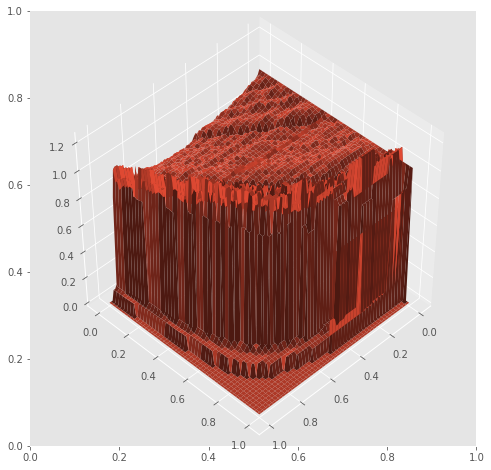

time: 1.44 s


In [33]:
X,Y = np.meshgrid(np.linspace(0,1, 100),np.linspace(0,1, 100))
etas_surface = etas_2d
fig, ax = plt.subplots(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
# Plot a 3D surface
ax.plot_surface(X, Y, etas_surface)
ax.view_init(45, 45)
plt.show()

In [34]:
pickle_in = open("etas_surface_dict.pickle","rb")
etas_surface_dict = pickle.load(pickle_in)
#etas_surface_dict = {}
etas_surface_dict['Palermo'] = etas_surface


pickle_out = open("etas_surface_dict.pickle","wb")
pickle.dump(etas_surface_dict, pickle_out)
pickle_out.close()

etas_surface_dict

{'NY': array([[1.        , 0.95418349, 0.92471336, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96911482, 0.94572765, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.97410736, 0.95689256, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]]),
 'Boston': array([[1.        , 0.94621367, 0.92299712, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.97340556, 0.95206791, ..., 0.        , 0.        ,
         0.        ],
        [1.        , 0.96708982, 0.94781127, ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.       

time: 60 ms


971 301
Number of cells with price above 5th percentile:  301
total number of cells:  971
number of cells within urban airbnb territory:  301



Mean travel times in minutes:  15.266287412329271
Mean travel times in minutes:  42.02363375784422
Mean travel times in minutes:  57.072838944259864


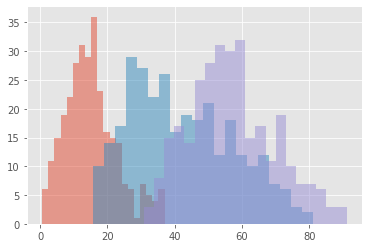

time: 3min 6s


In [35]:
from tqdm import tqdm_notebook

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))

print('total number of cells: ', len(polylist))

times_names = ['times_{}'.format(c) for c in range(1, len(centers)+1)]
times_dict = {name:[] for name in times_names}

plist = poly_prices[poly_prices.index.isin(keys)].geometry.tolist()
print('number of cells within urban airbnb territory: ', len(plist))
for poly in tqdm_notebook(plist):
    origin = ox.get_nearest_node(G, poly.centroid.coords[0][::-1])
    dists_to_centers = []
    for node, target in centers.items():
        try:
            if origin!=target:
                path = nx.shortest_path(G, origin, target, weight='length')
                edges = [ tuple( path[i:i+2] ) for i in range( len(path) - 1 ) ]
                dist = np.sum([G.get_edge_data(*edge)[0]['length'] for edge in edges])
                dists_to_centers.append(dist)
        except:
            pass
    if len(dists_to_centers) != 0:
        dists_to_centers = sorted(dists_to_centers)
        #print('distance list length equal to # of centers: ', len(dists_to_centers)==len(centers))
        if len(dists_to_centers)==len(centers):
            for n, dist in enumerate(dists_to_centers):
                time = (dist/3)/60
                times_dict['times_{}'.format(n+1)].append(time)
                #print(times_dict['times_{}'.format(n+1)][-1])
        else:
            print('Distance list length NOT equal to # of centers')

#print(distances_dict)
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=0.5)
plt.show()

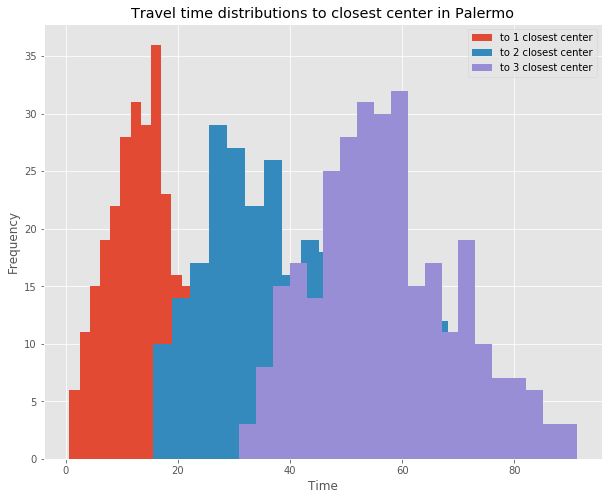

time: 709 ms


In [36]:
for center in range(1, len(centers)+1):
    times_dict['times_{}'.format(center)] = np.array(times_dict['times_{}'.format(center)])

fig, ax = plt.subplots(figsize=(10,8))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=1, label='to {} closest center'.format(center))
plt.title('Travel time distributions to closest center in Palermo')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [37]:
pickle_in = open("City_Accessibility.pickle","rb")
access_dict = pickle.load(pickle_in)
#access_dict = {}
access_dict['Palermo'] = times_dict


pickle_out = open("City_Accessibility.pickle","wb")
pickle.dump(access_dict, pickle_out)
pickle_out.close()

access_dict

{'Paris': {'times_1': array([ 4.73219737,  4.40047807,  7.81577632,  7.07926754,  6.7129386 ,
          7.48037281, 10.85755263,  8.41227193, 14.20045614, 15.15502193,
         16.00692982, 15.80582895, 14.35941228, 14.10681579, 12.26687281,
         13.89203947, 14.31310965, 15.99389474, 16.77728947, 17.82112281,
         20.19769737, 20.40849561, 21.93033333, 22.03087719, 20.6584386 ,
         20.62538596, 19.53197368, 20.61141228, 21.70609211, 23.22407018,
         21.70395614, 23.12607456, 22.79396053, 23.95434211, 21.49400439,
         21.55605702, 22.35374123, 22.36948246, 22.44162719, 21.54410965,
         21.93589912, 21.86757456, 21.86757456, 21.41060088, 21.92571491,
         22.93862281, 23.57200877, 25.13889474, 24.49192982, 26.04400877,
         26.815     , 38.90660088, 38.56507018, 37.89241228, 36.57546491,
         29.87379386, 27.54254825, 25.54755702, 26.98263158, 25.76562281,
         25.03485526, 25.37799123, 25.69687719, 26.07382018, 23.81846491,
         24.034649

time: 995 ms


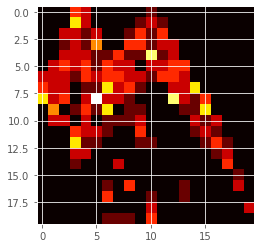

time: 374 ms


In [38]:
x = times_dict['times_{}'.format(1)]
y = times_dict['times_{}'.format(2)]
c_xy = np.histogram2d(x, y, 20)[0]
c_xx = np.histogram2d(x, x, 20)[0]
plt.imshow(c_xy, cmap='hot', interpolation='nearest')
plt.show()

In [39]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi_list = []
for center in range(1, len(centers)+1):
    mi_list.append(times_dict['times_{}'.format(center)])

mis = []
for pair in combinations_with_replacement(mi_list, 2):
    MI = calc_MI(pair[0], pair[1], 20)
    print(MI)
    mis.append(MI)
mis = np.array(mis)
avg_mi = np.mean(mis)
print('average mutual information = ', avg_mi)

2.768603328648488
0.8071194172608313
0.9223004256483174
2.858869192149817
1.0090458522252443
2.791669602625365
average mutual information =  1.8596013030930105
time: 29 ms


In [40]:
pickle_in = open("Time_distribution_mutual_information.pickle","rb")
MI_dict = pickle.load(pickle_in)
#MI_dict = {}
MI_dict['Palermo'] = avg_mi


pickle_out = open("Time_distribution_mutual_information.pickle","wb")
pickle.dump(MI_dict, pickle_out)
pickle_out.close()

MI_dict

{'Beijing': 1.629373608642793,
 'Florence': 2.0836399429599792,
 'Palermo': 1.8596013030930105,
 'Los_Angeles': 1.5625394117917575,
 'Moscow': 1.6041187048612595,
 'Porto': 1.6277816420571996,
 'Prague': 2.176480497902222,
 'Reykjavik': 1.3730161847793374,
 'Riga': 2.240374487910287,
 'Rome': 1.6095563575725969,
 'Seoul': 1.2910685865906735,
 'Siena': 2.7660068415344448,
 'Sydney': 1.2791891753795948,
 'Tallin': 2.3884073435187867,
 'Treviso': 2.631909071373147,
 'Valencia': 2.1872520197930965,
 'Venezia': 2.719891808939249,
 'Verona': 2.7080241467515376,
 'Vicenza': 2.6192607829416756,
 'Vienna': 1.4481542925032476,
 'Wellington': 2.1855226822614866,
 'Zurich': 2.462051055806955,
 'Aarhus': 2.2910468431831847,
 'Milan': 1.6107461389394335,
 'Busan': 1.9300969123092464,
 'Barcelona': 1.6449937230537024,
 'Bologna': 2.7317991260148045,
 'Bremen': 1.9957279038792954,
 'Brno': 2.4300669174144036,
 'Budapest': 2.219525897631017,
 'Dublin': 1.8513553186601897,
 'Boston': 1.1451275682586615,

time: 12 ms
